# Combine Supervised Learning Techniques With Unsupervised Learning Methods



### Class work for Introdution to Computer Vision, 
#### Lior Itzhak, guided by Or Katz and DR. Eyal Kats

## Introduction

At this demonstration, I will exhibit how we can make use of the advantages of supervised-learning techniques like deep CNNs and apply some unsupervised-learning methods on them.

Deep neural networks are often used for classifications tasks like discriminate between dogs and cats, Object detection and recognition and Big-Data analysis and so on. All of those tasks require a lot of labeled data (commonly tens of thousands of examples or more for each class) and long-time for training, and this could be expensive (acquiring the labeled data and computation resources). Additionally, if we have built a classifier between some categories, for example: 'dogs and cat' and later on, we'll want to generalize it to also classify between other categories, like 'humans and monkeys' we will have to rebuild the classifier. That because after the classifier network has been built, if we want to add a new class to it, it requires to train the classifier again using the old classes' data in addition to the new class's data (lots of it).

At this demonstration I'll exhibitting a way to use a deep CNN classifier to build a machine that can be used to classifiy different classes from the ones that were studied (trained).

The main techniques are to create a method that will tell us if one object is 'similar' the other, exactly like humans that can tell if a specific object is "the same" as the other even if they are seeing them for the first time.
So such as humans, we want to evaluate the "distance" between 2 objects and later on use it for clustering them into the different classes.

these techniques called "One-Shot learning."

for creating the distance-evaluation function, I'll make use of the deep CNN's amazing abilities to effectively learn features from a set of images.
I'll use the CNN as a features extractor that takes two images and return their "distance" and their location's (features) vector.

To do so, I will use the Siamese-Network technique.


### Siamese-Network

Siamese-networks are neural networks that use the same network's model (same weights) for multiple inputs (commonly 2 - twins). That means that the output is determined by the features that been taken from various inputs with the same features extractor methods (same network's weights).

By training the siamese-network to evaluate the difference between objects, we will get some features that separate one object from the other. We can assume that the same features can also be valid for different kinds of objects that are sharing the same main properties.




![siamese_NN.png](images/siamese_NN.png)


One more significant advantage of the siamese network is that it uses pair (or more) of images as inputs. In doing so, we increase the total amount of data from the number of images to the number of different pairs that can be selected. That is very significant because, for balance data, the total amount is the minimum between the number of 'false' (different) pairs and the number of 'true' (same) pairs, this number is much bigger than the original one.

### The Experiment

My experiment is to use an alphabets dataset (Omniglot) that contains 50 different handwriting alphabets with 20 examples of each character (class) and demonstrate efficient learning and generalization with a small amount of data.

The number of characters in each alphabet is between 20 to 50.

Because of the little number of examples of each character (class), a regular CNN that will try to classify an alphabet's characters will quickly overfit and will unable to classify new (unlearned) examples, additionally if we will need to classify characters of an alphabet that never has been seen by the model we will usually fail (different alphabet then the one we trained on)

My goal is to build a 'machine' that will able to evaluate the distance between 2 different character's images and to use this evaluation to classify unseen alphabets, I will do so by trying to teach a siamese network the features that separate each different character from the other.


![alphabets.png](images/alphabets.png)

### The Traditional Way

First, lets examinee the traditional training of the CNN classifier by creating a model to classify the characters of a specific alphabet.

The model has a character's image as an input and an output matching the number of different characters, each neuron at the output representing a different character from the alphabet.

Each character contains 20 different handwriting examples that divided into the train set and the test (evaluation) set.

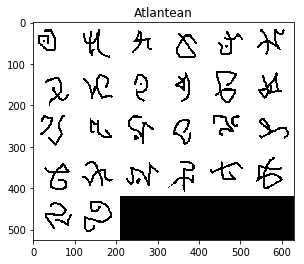

Number of different characters : 26


In [71]:
alphabet_trd = alphabets_test[2]
alphabet_trd.display()

In [ ]:
from sklearn.model_selection import train_test_split

#load alphabet characters
x_traditional,y_traditional = alphabet_trd.create_chars_dataset(load_images=False)

#change y format to one-hote for classification model
y_traditional = np.array([one_hote(y,alphabet_trd.chars.shape[0]) for y in y_traditional])
x_traditional = np.array([init_image(x,shape = input_shape) for x in x_traditional])
#split test and train charaters
x_train_trd,x_test_trd,y_train_trd,y_test_trd = train_test_split(x_traditional,y_traditional,
                                                                test_size=0.3,random_state=1,
                                                                    stratify=y_traditional)

#build the CNN model
keras_model_trd =  keras.applications.mobilenet.MobileNet(weights= None,include_top=True ,
                                                          input_shape=input_shape,classes=alphabet_trd.chars.shape[0])

keras_model_trd.compile(optimizer ='adadelta',
                loss='categorical_crossentropy',
                  metrics = ['acc'])

his_trd = keras_model_trd.fit(x=x_train_trd,y=y_train_trd,batch_size=32,epochs=40,validation_split=0.1,shuffle=True)

In [ ]:
#plot training history
plt.subplot(121)
plt.plot(his_trd.history['acc'])
plt.plot(his_trd.history['val_acc'])
plt.title('acc')
plt.legend(['train acc', 'val acc'])
plt.subplot(122)
plt.plot(his_trd.history['loss'])
plt.plot(his_trd.history['val_loss'])
plt.title('loss')
plt.legend(['train loss', 'val loss'])
plt.show()

overfitting, not enough data to generalize the training:


![traing_plot_traditional.png](images/traing_plot_traditional.png)

accuracy = 7.692%
Confusion matrix, without normalization


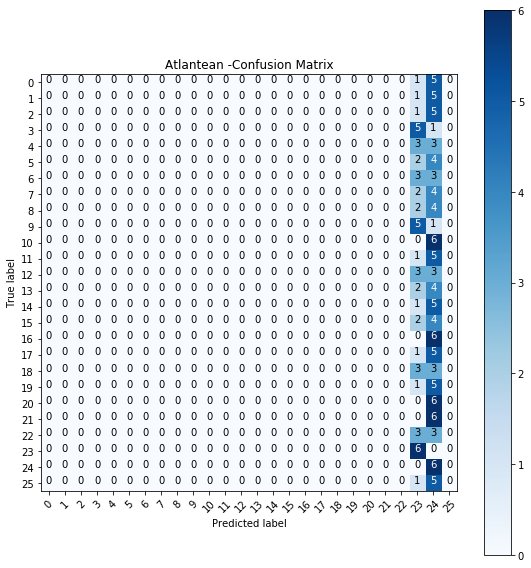

In [45]:
pred = keras_model_trd.predict(x=x_test_trd)
_ =evaluate_classifier(keras_model_trd ,x_test_trd, y_test_trd,argmax=True,title = alphabet_trd.name)

As you see, using a traditional technique to train the classifier while having a small number of examples per class creates overfitting, the classifier quickly learn the training examples and fail to generalize it to different cases.

To overcome this problem, we must use a different technique or add more (much more) examples.

### Unsupervise Clustering 

ARI = 0.071
alphabet = Atlantean
number of characters = 26


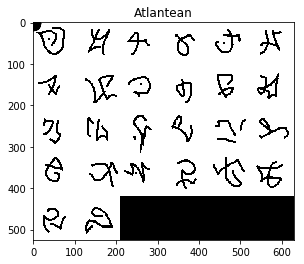

Number of different characters : 26


<Figure size 432x288 with 0 Axes>

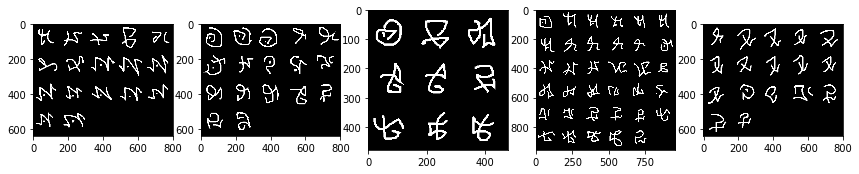

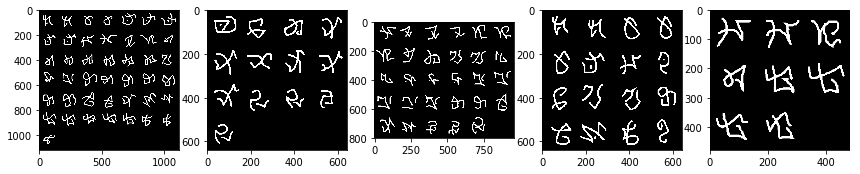

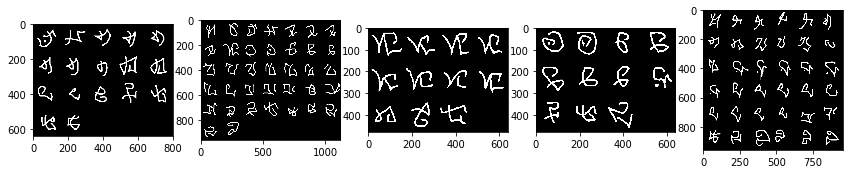

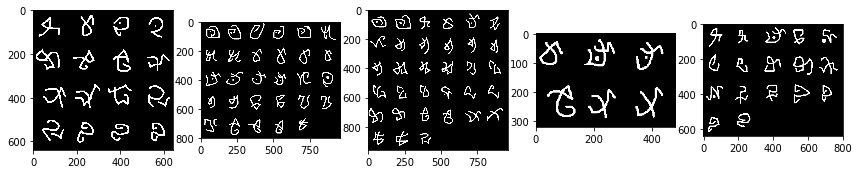

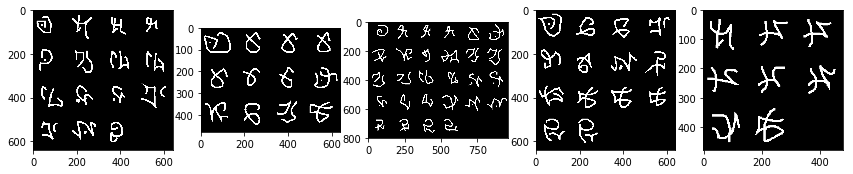

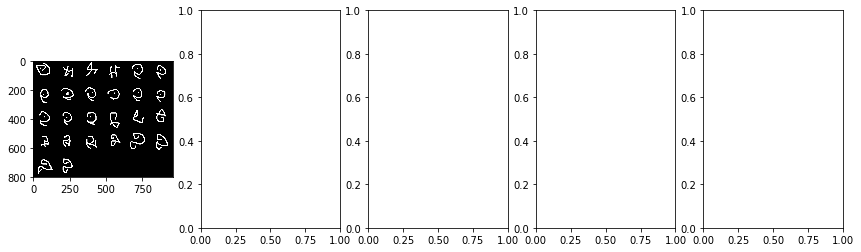

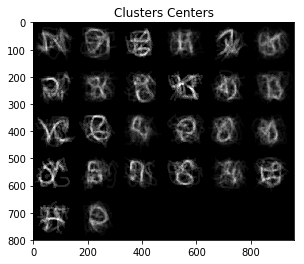

In [46]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

#get the number of clusters
n_classes = alphabet_trd.chars.shape[0]
x_traditional_flat = np.array([x.flatten() for x in x_traditional])

kmeans = KMeans(n_clusters=n_classes).fit(x_traditional_flat)
kmeans.labels_
centers = kmeans.cluster_centers_

#display the clusters on 2-Dims plot 
plt.scatter(x_traditional_flat[:, 0],x_traditional_flat[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

#evaluate the clusters [0,1] ,0 is lowest, 1 highest
ARI = adjusted_rand_score(kmeans.labels_,y_traditional.argmax(1))
print('ARI = ' + format(ARI,".3f"))
print("alphabet = "+alphabet_trd.name)
print("number of characters = "+str(alphabet_trd.chars.shape[0]))
alphabet_trd.display()

num_of_plot = 5
tmp = kmeans.cluster_centers_.shape[0]%num_of_plot
for cluster in range(kmeans.cluster_centers_.shape[0]):
    if cluster % num_of_plot == 0:
        plt.subplots_adjust(right = 2)
        f, axarr = plt.subplots(1,num_of_plot)
    cluster_x = x_traditional[kmeans.labels_ == cluster]
    ax.set_title("cluster "+str(cluster))
    axarr[cluster % num_of_plot].imshow(concat_images(cluster_x)[:,:,0],cmap='gray')
plt.subplots_adjust(right = 2)
plt.show()

print("\n\n")
clusters_image = kmeans.cluster_centers_.reshape(kmeans.cluster_centers_.shape[0],*x_traditional.shape[1:])
plt.title('Clusters Centers')
plt.imshow(concat_images(clusters_image)[:,:,0],cmap='gray')
plt.show()

As you see, using unsupervised clustering with no preprocessing on the data returns not very good results, also the clustering of high dimensional data is affecting the time and the complexity of the algorithm.

Later on, I'll demonstrate how the 'distance technique' also helping as preprocessing for clustering tasks.

# Now Improve It By Distance Method

## The Code

In [6]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import random 
import re 
import os
from random import shuffle

dataset_path = r'C:\Users\liori\Desktop\Projects\Computer vision\Computer Vision Curse Final Project\OM_dataset'

In [7]:
class Alphabet():
    def __init__(self ,name ,chars):
        self.name = name
        self.chars = chars
    

    def get_alphabet_image(self):
        chars = []
        for char_type in self.chars:
            example = np.random.randint(char_type.shape[0])
            chars.append(char_type[example])
        chars = np.array(chars)
        return concat_images(chars) 

    def create_chars_dataset(self, load_images = False):
        X = [] ;Y = []
        class_index = 0
        for chars in self.chars:
            for char in chars:
                if load_images:
                    X.append(cv2.imread(char))
                else:
                    X.append(char)
                Y.append(class_index)
            class_index+=1
        return np.array(X),np.array(Y)
    
    def display(self):
        alphabet_img = self.get_alphabet_image()
        plt.title(self.name)
        plt.imshow(alphabet_img)
        plt.show()
        print('Number of different characters : '+str(self.chars.shape[0]))
        
#dataset class
class OmniglotDataset():
  
    def __init__(self ,path):
        self.path = path
        self.train_path = os.path.join(path,'images_background')
        self.test_path = os.path.join(path,'images_evaluation')

        
    def load_data(self,test_train = 'train',load_imgs = False):
        #if load_imgs is false this method will load only imgs path
        database_path = [self.train_path,self.test_path][int(test_train == 'test')]
        alphabets_dict = dict()  
        for ii,row in enumerate(os.walk(database_path)):#row = tuple(path,Dirs,Files)
            path_1,dic_1,data_1 = row
            if len(data_1) == 0:
                alphabets_name = os.path.basename(path_1)
                
            #add charachers to the alphabet
            if len(data_1)>0:
                if load_imgs:
                    alphabets_dict.setdefault(alphabets_name,[]).append(
                    [ cv2.imread(os.path.join(path_1,file_name)) for file_name in data_1])
                else:
                    alphabets_dict.setdefault(alphabets_name,[]).append(
                    [ os.path.join(path_1,file_name) for file_name in data_1])
                
        alphabets = []
        for key in alphabets_dict.keys():
            t = Alphabet(key ,np.array(alphabets_dict[key]))
            alphabets.append(t)
                             
        return np.array(alphabets)
    
    
    
    

def concat_images(images, num_of_images = None):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,h,w,d = images.shape
    if num_of_images is None or nc > num_of_images:
        num_of_images = nc
    n = np.ceil(np.sqrt(num_of_images)).astype(np.uint8)
    ny = num_of_images//n + (num_of_images%n>0)
    img = np.zeros((ny*h,n*w,d))
    for p in range(nc):
        y = p//n ; x = p%n
        img[y*h:h*(y+1),x*w:w*(x+1)] = images[p][:,:]
    return img.astype(images.dtype) 


def one_hote(y,n):
    I = np.zeros(n)
    I[y]= 1
    return I

def normalize(tensor):
    tensor -= tensor.min()
    return tensor/tensor.max()

# def normalize(tensor):
#     return cv2.normalize(tensor, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

def float2int(images):
    return (255*images).astype(np.uint8)

def int2float(images):
    return images.astype(np.float64)/256



In [8]:
def crop_countors(img ,return_x_y = False):
    if len(img.shape) == 2:
        img = img.reshape(*img.shape,1)
        
    if img.shape[2] != 1:
            img_gray =  cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img
    img2, contours, hierarchy = cv2.findContours(img_gray,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        
    points = []
    for kk in contours:
        for ii in kk:
            for jj in ii:
                    points.append([jj[0],jj[1]])
    points = np.array(points)
    if points.shape[0] == 0:
        return img
    rx,ry,rw,rh = cv2.boundingRect(points)       
    
    if return_x_y:
        return img[ry:ry+rh,rx:rx+rw] , rx,ry
    return img[ry:ry+rh,rx:rx+rw]       

In [9]:
#prepare the image to enter tje machine (Model)
#init image to a specific shape and thresholding
#resize the image to match its countors - not in use here
#changes the background to black and the black pixels to white
def init_image(img ,shape = (224,224,3) ,match_countors = False, gray_scale = True ,thresh = 200):
    if gray_scale:
        #change imgs colors to gray_scale
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        
    if thresh != None:
        ret,thresh_img = cv2.threshold(img,thresh,255,0)
        img = thresh_img     
    
    #white <> black
    img = 255 - img
    
    if match_countors:
        img = crop_countors(img) 
          
    #resize img to match output shape (bast fit with no scaling changes)
    resize_ratio = np.array([shape[i]/img.shape[i] for i in range(2)])
    resize_ratio = resize_ratio.min()
    img = cv2.resize(img, (int(img.shape[1]*resize_ratio),int(img.shape[0]*resize_ratio)),
                     interpolation = cv2.INTER_AREA)
    
    #normalize image to [0,1]
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    if len(img.shape) == 2 and len(shape) == 3:
        img = img.reshape((img.shape[0],img.shape[1],1))
    
    #img and output could be with differnt shapes (not integer resize_ratio)
    if img.shape[0] == shape[0] and img.shape[1] == shape[1] and img.shape[2] == shape[2]:
        output = img
    else:
        output = np.zeros(shape,dtype=np.float32)
        sy = (output.shape[0]-img.shape[0])//2
        sx = (output.shape[1]-img.shape[1])//2
        if len(output.shape) == 3:
            for dim in range(output.shape[2]):
                output[sy:sy+img.shape[0],sx:sx+img.shape[1],dim] = img[:,:,dim%img.shape[2]]
        else:
            output[sy:sy+img.shape[0],sx:sx+img.shape[1]] = img[:,:]

    return output

loading the alpabets dataset , 30 as training set (10% validation) and 20 as evaluation set (testing)

In [10]:
dataset = OmniglotDataset(dataset_path)
alphabets_train = dataset.load_data(load_imgs=True)
alphabets_test = dataset.load_data(test_train = 'test',load_imgs=True)
alphabets_valid = []

random_indexs = random.choices(population=range(alphabets_train.shape[0]), k=alphabets_train.shape[0]//10)
for index in random_indexs:
    alphabets_valid.append(alphabets_train[index])
    alphabets_train = np.delete(alphabets_train, index) 
alphabets_valid = np.array(alphabets_valid)

presenting the alphabets

In [11]:
print('train alphabets :')
print([alphabet.name for alphabet in alphabets_train])
print('\nvalidation alphabets :')
print([alphabet.name for alphabet in alphabets_valid])
print('\ntest alphabets :')
print([alphabet.name for alphabet in alphabets_test])


train alphabets :
['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Futurama', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh']

validation alphabets :
['Early_Aramaic', 'Grantha', 'Sanskrit']

test alphabets :
['Angelic', 'Atemayar_Qelisayer', 'Atlantean', 'Aurek-Besh', 'Avesta', 'Ge_ez', 'Glagolitic', 'Gurmukhi', 'Kannada', 'Keble', 'Malayalam', 'Manipuri', 'Mongolian', 'Old_Church_Slavonic_(Cyrillic)', 'Oriya', 'Sylheti', 'Syriac_(Serto)', 'Tengwar', 'Tibetan', 'ULOG']


presenting the char image before and after adjusting to the machine

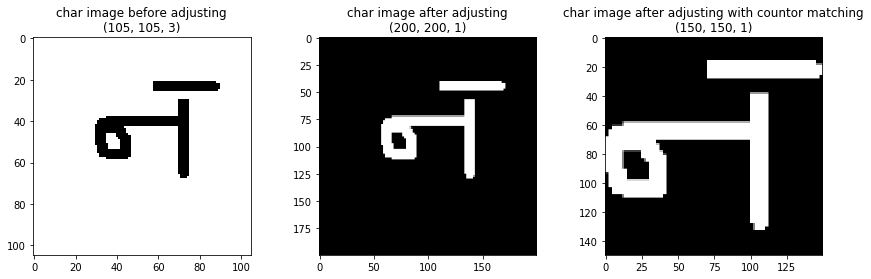

In [12]:
img = alphabets_valid[2].chars[19][3]
img_init = init_image(img ,shape = (200,200,1) ,match_countors = False, gray_scale = True ,thresh = 220)
img_init2 = init_image(img ,shape = (150,150,1) ,match_countors = True, gray_scale = False ,thresh = 220)

fig=plt.figure()
plt.subplots_adjust(right = 2)

ax=fig.add_subplot(1,3,1)  
ax.set_title("char image before adjusting\n"+str(img.shape))
ax.imshow(img,cmap='gray')

ax=fig.add_subplot(1,3,2)  
ax.set_title("char image after adjusting\n"+str(img_init.shape))
ax.imshow(img_init[:,:,0],cmap='gray')

ax=fig.add_subplot(1,3,3)  
ax.set_title("char image after adjusting with countor matching\n"+str(img_init2.shape))
ax.imshow(img_init2[:,:,0],cmap='gray')
plt.show()

Some little augmentation functions to enlarge the diversity of the inputs - to increase the chances of generalizing the training data

I choose some augmentations that that will not har, the data:

Flips (on the 2 inputs simultaneously)

Rotate (small degrees)

Move (move the contures of the picture a little)

Aspect

In [13]:
def rotateAndScale(img, scaleFactor = 1, degreesCCW = 30):
    (oldY,oldX) = img.shape[:2] #note: numpy uses (y,x) convention but most OpenCV functions use (x,y)
    M = cv2.getRotationMatrix2D(center=(oldX/2,oldY/2), angle=degreesCCW, scale=scaleFactor) #rotate about center of image.

    newX,newY = oldX*scaleFactor,oldY*scaleFactor
    #include this if you want to prevent corners being cut off
    r = np.deg2rad(degreesCCW)
    newX,newY = (abs(np.sin(r)*newY) + abs(np.cos(r)*newX),abs(np.sin(r)*newX) + abs(np.cos(r)*newY))

    #the warpAffine function call, below, basically works like this:
    # 1. apply the M transformation on each pixel of the original image
    # 2. save everything that falls within the upper-left "dsize" portion of the resulting image.

    #So I will find the translation that moves the result to the center of that region.
    (tx,ty) = ((newX-oldX)/2,(newY-oldY)/2)
    M[0,2] += tx #third column of matrix holds translation, which takes effect after rotation.
    M[1,2] += ty

    rotatedImg = cv2.warpAffine(img, M, dsize=(int(newX),int(newY)), borderValue=(255, 255, 255))
    return rotatedImg


def move(image , move_x, move_y):
    output = np.ones_like(image)*255
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            if image.shape[1]>x+move_x>=0 and image.shape[0]>y+move_y>=0:
                output[y+move_y][x+move_x] = image[y][x]
    return output

def change_aspect(img ,ratio ,axis = 0 ):
    if axis == 0:
        img = cv2.resize(img,(img.shape[1] ,int(ratio*img.shape[0])), interpolation = cv2.INTER_AREA)
    else:
        img = cv2.resize(img,(int(img.shape[1]*ratio) ,img.shape[0]), interpolation = cv2.INTER_AREA)                          
    return img

def random_move_countor(img ,output):
    if output.shape[0]<img.shape[0]  or output.shape[1]<img.shape[1] <0:
        return img
    img = crop_countors(img)

    x = np.random.randint(0,output.shape[1]-img.shape[1]+1)
    y = np.random.randint(0,output.shape[0]-img.shape[0]+1)
    output[y:y+img.shape[0],x:x+img.shape[1]] =  img[:,:]
    return output

def random_resize_countor(img,min_ratio = 0.5,max_ratio = 1 ,background = 0):
    img_c,x,y = crop_countors(img, return_x_y = True)
    out = img.copy()
    
    if len(img.shape) == 2:
        out[y:y+img_c.shape[0],x:x+ img_c.shape[1]] = background
    else:
        out[y:y+img_c.shape[0],x:x+img_c.shape[1],:] = background

    c_center_x = (img_c.shape[1]//2 +x) 
    c_center_y = (img_c.shape[0]//2 +y) 

    c_center = [c_center_y,c_center_x]
    #resize img to match output shape (bast fit with no scaling changes)
    tmp = [c_center[ii]/img_c.shape[ii] for ii in range(2)]
    tmp += [(img.shape[ii]-c_center[ii])/img_c.shape[ii] for ii in range(2)]

    tmp.append(max_ratio)
    max_ratio = np.array(tmp).min()    
 
    resize_ratio = (max_ratio-min_ratio)*np.random.random() + min_ratio
    
    img_c = cv2.resize(img_c, 
                     (int(img_c.shape[1]*resize_ratio),int(img_c.shape[0]*resize_ratio)),
                     interpolation = cv2.INTER_AREA)
    

    x_start = (c_center_x - img_c.shape[1]//2)
    y_start = (c_center_y - img_c.shape[0]//2)
    
    out [y_start:y_start+img_c.shape[0], x_start:x_start+img_c.shape[1]] =  img_c[:,:]
    
    return out

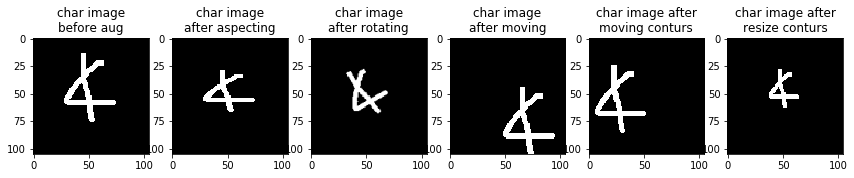

In [14]:
img = alphabets_valid[0].chars[0][0]
img_init_reg = init_image(img ,shape = (105,105,1) ,match_countors = False, gray_scale = True ,thresh = 220)

img_init_aspect = change_aspect(img,0.6)
img_init_aspect = init_image(img_init_aspect ,shape = (105,105,1) ,match_countors = False, gray_scale = True ,thresh = 220)

img_rotate_init = rotateAndScale(img, scaleFactor = 1, degreesCCW = 30)
img_rotate_init = init_image(img_rotate_init ,shape = (105,105,1) ,match_countors = False, gray_scale = True ,thresh = 220)

img_move_init = move(img, 20,30)
img_move_init = init_image(img_move_init ,shape = (105,105,1) ,match_countors = False, gray_scale = True ,thresh = 220)

img_move_c_init = 255 - random_move_countor(255 - img, np.zeros((105,105,3),dtype=np.uint8)*255)
img_move_c_init = init_image(img_move_c_init ,shape = (105,105,1) ,match_countors = False, gray_scale = True ,thresh = 220)

img_size_c_init = 255 - random_resize_countor(255 - img,min_ratio = 0.4,max_ratio = 1.8)
img_size_c_init = init_image(img_size_c_init ,shape = (105,105,1) ,match_countors = False, gray_scale = False ,thresh = 220)


fig=plt.figure()
plt.subplots_adjust(right = 2)

ax=fig.add_subplot(1,6,1)  
ax.set_title("char image\nbefore aug")
ax.imshow(img_init_reg[:,:,0],cmap='gray')

ax=fig.add_subplot(1,6,2)  
ax.set_title("char image\nafter aspecting")
ax.imshow(img_init_aspect[:,:,0],cmap='gray')

ax=fig.add_subplot(1,6,3)  
ax.set_title("char image\nafter rotating")
ax.imshow(img_rotate_init[:,:,0],cmap='gray')

ax=fig.add_subplot(1,6,4)  
ax.set_title("char image\nafter moving")
ax.imshow(img_move_init[:,:,0],cmap='gray')

ax=fig.add_subplot(1,6,5)  
ax.set_title("char image after\nmoving conturs")
ax.imshow(img_move_c_init[:,:,0],cmap='gray')

ax=fig.add_subplot(1,6,6)  
ax.set_title("char image after\nresize conturs")
ax.imshow(img_size_c_init[:,:,0],cmap='gray')


plt.show()


In [15]:
def apply_random_aug(img1 ,img2 ,probability = 0.2 ,noise_ratio = 0):
    if np.random.random() < probability:
        n_augs = 0
        while n_augs < 1 or np.random.random() < 0.3:
            n_augs+=1
            rand = random.random()
            if rand < 0.20 :
                #random axis choise
                axis = np.random.randint(0,1)
                img1 = cv2.flip( img1,axis)
                img2 = cv2.flip( img2,axis)
            elif rand < 0.40:
                rotate_angle1 = random.uniform(-30, 30)
                rotate_angle2 = rotate_angle1
                if noise_ratio > 0:
                    rotate_angle1 +=  rotate_angle1*(0.5 -np.random.random())*noise_ratio
                    rotate_angle2 +=  rotate_angle2*(0.5 -np.random.random())*noise_ratio
                img1 = rotateAndScale( img1,degreesCCW = rotate_angle1)
                img2 = rotateAndScale( img2,degreesCCW = rotate_angle2)
            elif rand < 0.60:
                move_pixels_x1 = random.uniform(-img1.shape[1]*0.1, img1.shape[1]*0.1)
                move_pixels_y1 = random.uniform(-img1.shape[0]*0.1, img1.shape[0]*0.1)
                move_pixels_x2 = random.uniform(-img1.shape[0]*0.1, img1.shape[0]*0.1)
                move_pixels_y2 = random.uniform(-img1.shape[1]*0.1, img1.shape[1]*0.1)
                if noise_ratio > 0:
                    move_pixels_x1 += move_pixels_x1*(0.5 -np.random.random())*noise_ratio
                    move_pixels_y1 += move_pixels_y1*(0.5 -np.random.random())*noise_ratio
                    move_pixels_x2 += move_pixels_x2*(0.5 -np.random.random())*noise_ratio
                    move_pixels_y2 += move_pixels_y2*(0.5 -np.random.random())*noise_ratio
                img1 = move( img1,int(move_pixels_x1),int(move_pixels_y1))
                img2 = move( img2,int(move_pixels_x2),int(move_pixels_y2))
            elif rand < 0.65:
                img1 = 255 - random_move_countor(255 - img1, np.zeros(img1.shape,dtype=img1.dtype)*255)
                img2 = 255 - random_move_countor(255 - img2, np.zeros(img2.shape,dtype=img2.dtype)*255)
                
                
            elif rand < 0.80:
                img1 = 255 - random_resize_countor(255 - img1,min_ratio = 0.6,max_ratio = 1.4)
                img2 = 255 - random_resize_countor(255 - img2,min_ratio = 0.6,max_ratio = 1.4)

            elif rand < 1:
                axis = np.random.randint(0,1)
                ratio1 = random.uniform(0.85, 1.15)
                ratio2 = random.uniform(0.85, 1.15)
                if noise_ratio > 0:
                    ratio1 +=  ratio1*(0.5 -np.random.random())*noise_ratio
                    ratio2 +=  ratio2*(0.5 -np.random.random())*noise_ratio
                img1 = change_aspect(img1 ,ratio1 ,axis)
                img2 = change_aspect(img2 ,ratio2 ,axis)
                
    return img1,img2

show some random augmentations


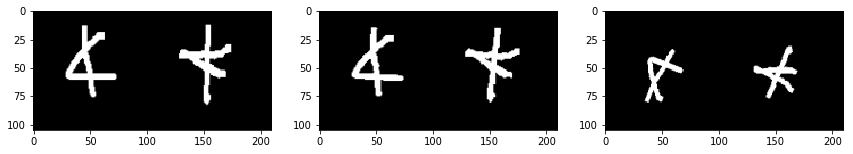

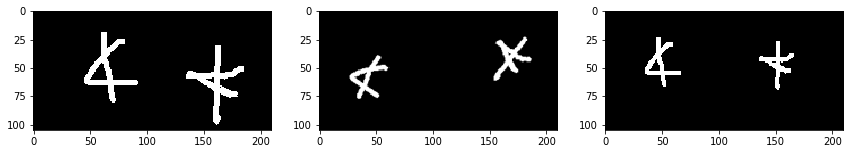

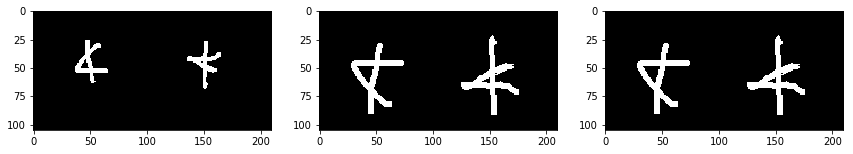

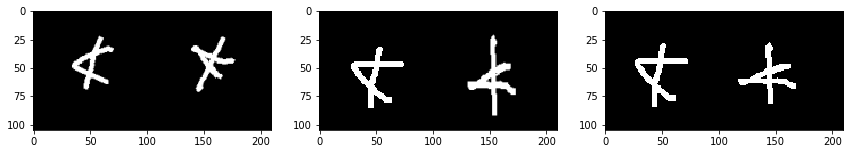

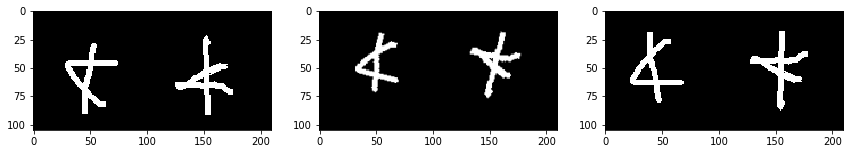

In [16]:
img1 = alphabets_valid[0].chars[0][0]
img2 = alphabets_valid[0].chars[0][1]

print('show some random augmentations')
for index in range (5):
    f, axarr = plt.subplots(1,3)
    for ii in range(3):
        plt.subplots_adjust(right = 2)
        img1_a, img2_a= apply_random_aug(img1 ,img2 ,probability = 1 ,noise_ratio = 0.5)
        img1_a = init_image(img1_a ,shape = (105,105,1) ,match_countors = False, gray_scale = True ,thresh = 220)
        img2_a = init_image(img2_a ,shape = (105,105,1) ,match_countors = False, gray_scale = True ,thresh = 220)
        img_c = concat_images(np.array([img1_a,img2_a]))
        axarr[ii].imshow( img_c[:,:,0],cmap='gray')
    plt.show()   

creatting a batch generator to generat a set of 2 characters, half are the same class and half different (balance set)

In [17]:
def batch_generator(alphabets,batch_size = 16,shape = (224,224,3),load_img = True ,useAugs = False,probability=0.2 ,noise_ratio = 0.4):
    half_batch = batch_size//2
    #create targets:
    #first half same pairs  (0 -> false - not different) 
    #second differnet pairs (1 -> true - are different)
    targets = np.zeros(shape = (half_batch*2,1),dtype=np.float64)
    targets[half_batch:] = 1.
    while True:
        pairs_list = []
        #create first half batch with true pairs
        for _ in  range(half_batch):
            #pick a random alphabet
            alphabet = alphabets[np.random.randint(0,alphabets.shape[0])]
            #pick a random char from the alphabet
            n_chars = alphabet.chars.shape[0]
            random_char_idx =  np.random.randint(0,n_chars)
            #pick 2 different random chars examples (of the same char)
            n_examples = alphabet.chars[random_char_idx].shape[0]
            exp_idx1 = np.random.randint(n_examples)
            exp_idx2 =  (exp_idx1 + np.random.randint(1,n_examples) )% n_examples
            
            char1 = alphabet.chars[random_char_idx][exp_idx1]
            char2 = alphabet.chars[random_char_idx][exp_idx2]
            pairs_list.append([char1,char2])

        #create second half batch with false pairs       
        for _ in range(half_batch):
            #pick a random alphabet
            alphabet = alphabets[np.random.randint(0,alphabets.shape[0])]
            #pick 2 different random chars from the alphabet
            n_chars = alphabet.chars.shape[0]
            random_char_idx1 =  np.random.randint(0,n_chars)
            random_char_idx2 =  (random_char_idx1 + np.random.randint(1,n_chars))%n_chars
            #pick 2 random chars examples (of different chars)
            n_examples1 = alphabet.chars[random_char_idx1].shape[0]
            n_examples2 = alphabet.chars[random_char_idx2].shape[0]
            exp_idx1 = np.random.randint(n_examples1)
            exp_idx2 = np.random.randint(n_examples2)
            char1 = alphabet.chars[random_char_idx1][exp_idx1]
            char2 = alphabet.chars[random_char_idx2][exp_idx2]
            pairs_list.append([char1,char2])

        if load_img == True:
            pairs_list = [[cv2.imread(img1_path) ,cv2.imread(img2_path)] for img1_path,img2_path in pairs_list]
            
        if useAugs == True:
            pairs_list = [apply_random_aug(img1,img2,probability,noise_ratio) for img1,img2 in pairs_list]
        
        #unzip and prepare the imgs for the input layer    
        imgs_1,imgs_2 = zip(*[[init_image(img1,shape),init_image(img2,shape)] for img1,img2 in pairs_list])
        imgs_np1 = np.array(imgs_1)
        imgs_np2 = np.array(imgs_2)
        
        yield [imgs_np1,imgs_np2],targets      

demonstrate a single batch

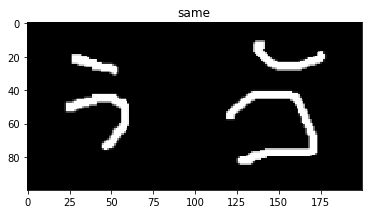

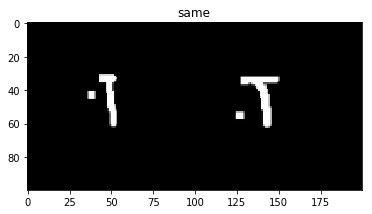

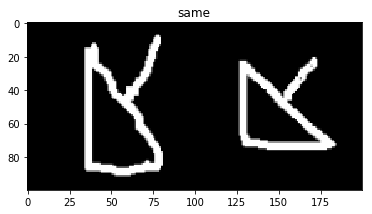

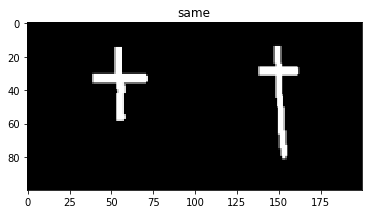

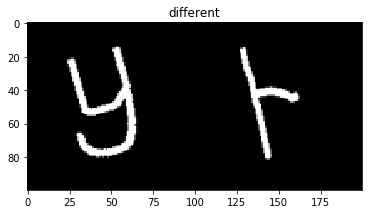

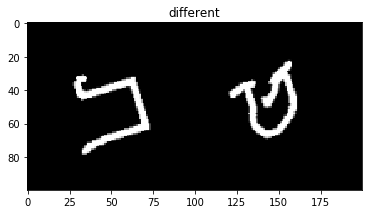

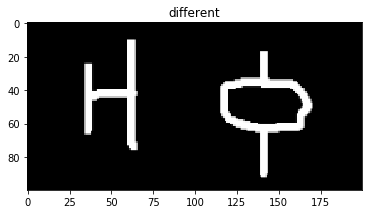

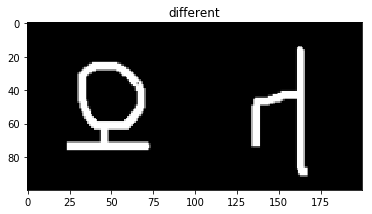

In [18]:
batch = batch_generator(alphabets_train,8,(100,100,1),useAugs=True,probability=1,noise_ratio = 0.4,load_img = False)
x,y = next(batch)
for index in range (y.shape[0]):
    plt.title(['same','different',][int(y[index])])
    img_c = concat_images(np.array([x[0][index],x[1][index]]))
    plt.imshow(img_c[:,:,0],cmap = 'gray')
    plt.show()

### Architecture

<img src="images/siamese_model.png" alt="Drawing" style="width:50%"  align="middle"/>

### Example:

<img src="images/siamese_model_predict.png" alt="Drawing" style="width: 100%"  align="middle"/>

Creating a CNN using Keras's applications models I chose the 'Mobilenet' model because of its very lite and its ability to run on my laptop, for this experiment its good enough but for a real task you may use a more complex network.


In [19]:
from keras.preprocessing import image
from keras.layers import Lambda, Dense, Flatten,MaxPooling2D,Conv2D ,Dropout ,Input,Activation
import keras
from keras.layers import Average
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
from sklearn.utils import shuffle

input_shape = (160,160,1)

creating the model

In [20]:
#load keras model from keras
keras_model =  keras.applications.mobilenet.MobileNet(weights= None, include_top=True ,input_shape=input_shape)
print(keras_model.layers[-1])
print(keras_model.layers[-2])

#remove softmax layer (layer -2)
keras_model.layers.pop()
keras_model.layers.pop()

#add sigmoid activation
inner_out = Activation('sigmoid', name='sigmoid')(keras_model.layers[-1].output)
inner_out = Flatten(name='flatten')(inner_out)

#use keras model as the shared inner model of the siamese network
inner_model= Model(inputs=[keras_model.input], outputs=[inner_out])

#create twin inputs for the siamese network
left_input = Input(input_shape)
right_input = Input(input_shape)

#get the twins output of the inner model
out_left = inner_model(left_input)
out_right = inner_model(right_input)

# Getting the L1 Distance between the 2 twins's outputs, 
#to evalute the features distance between the two inputs
L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))
out = L1_layer([out_left, out_right])

out = Dropout(0.05)(out)
#create a decision layer
out = Dense(1,activation='sigmoid')(out)

#create the siamese model
siamese_model = Model([left_input, right_input], out)


In [21]:
inner_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 1)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 161, 161, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 80, 80, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 80, 80, 32)        128       
__________

In [22]:
siamese_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 160, 160, 1)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 160, 160, 1)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1000)         4253288     input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1000)         0           model_1[1][0]                    
          

In [ ]:
siamese_model.compile(optimizer ='adadelta',
                loss='binary_crossentropy' ,
                  metrics = ['acc'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0, patience=10,
                                               verbose = 1, restore_best_weights=True)

epoch_his = []

In [ ]:
batch_size = 16

train_gen = batch_generator(alphabets_train,
                            batch_size = batch_size, shape = input_shape,
                            useAugs=True, probability=0.25
                            ,noise_ratio = 0.2,
                            load_img = False)

valid_gen = batch_generator(alphabets_valid,
                            batch_size = batch_size, shape = input_shape,
                            useAugs=False,
                            load_img = False)

In [ ]:
his = siamese_model.fit_generator(train_gen,
                        steps_per_epoch = 250,
                        validation_steps = 20,
                        validation_data = valid_gen,
                        verbose=1, callbacks=[early_stopping],
                        epochs=30 )
epoch_his.append(his)

In [ ]:
#plot training history
plt.subplot(121)
plt.plot(his.history['acc'])
plt.plot(his.history['val_acc'])
plt.title('acc')
plt.legend(['train acc', 'val acc'])
plt.subplot(122)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('loss')
plt.legend(['train loss', 'val loss'])
plt.show()

training plot:
![training_plot.png](images/training_plot.png)

adding more augmented data after the validation improvement start to decline

In [ ]:
siamese_model.compile(optimizer ='adam',
                loss='binary_crossentropy' ,
                  metrics = ['acc'])


train_gen = batch_generator(alphabets_train,
                            batch_size = batch_size, shape = input_shape,
                            useAugs=True, probability=0.65
                            ,noise_ratio = 0.3,
                            load_img = False)

valid_gen = batch_generator(alphabets_test,
                            batch_size = batch_size, shape = input_shape,
                            useAugs=False,
                            load_img = False)

his1 = siamese_model.fit_generator(train_gen,
                        steps_per_epoch = 300,
                        validation_steps = 20,
                        validation_data = valid_gen,
                        verbose=1, callbacks=[early_stopping],
                        epochs=20 )
epoch_his.append(his1)

training plot:
![training_plot_s2.png](images/training_plot_s2.png)

In [ ]:
#siamese_model.save('final_pro_omn_drop_3.h5')

In [23]:
from keras.models import load_model
del siamese_model
siamese_model = load_model('final_pro_omn2.h5') ##('final_pro_omn8.h5')

(siamese_model.inputs[0].shape[1:])


TensorShape([Dimension(160), Dimension(160), Dimension(1)])

I trained the model a bit more until the trained model got about 91% accuracy and around 0.20 loss on the train's data   
and 88%  accuracy and around 0.23 loss on validation's data

It can be improved using a more complex model and more training time but for this demonstration is enough.

evaluation functions:

In [24]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title = None, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(['Confusion Matrix',str(title)+' -Confusion Matrix'][title is not None])
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label') ; plt.xlabel('Predicted label')
    plt.tight_layout()
    
def display_confusion_matrix(T,Y,names,figsize =[8,8] ,title = None):
    acc =  (sum(T[:] == Y[:]) / T.shape[0])*100
    print('accuracy = ' + str(format(acc,".3f")) + '%')
    #Plot confusion matrix    
    cnf_matrix = confusion_matrix(T,Y)
    np.set_printoptions(precision=2)
    plt.figure(figsize=figsize)
    plot_confusion_matrix(cnf_matrix, classes=names, normalize=False,title=title)
    plt.show()

In [25]:
from sklearn.utils import shuffle
    
def evaluate_classifier(classifier ,X, T, class_names =None, generator = None,steps=None,figsize =[8,8] ,title = None,argmax=False):
    if generator is None or steps is None:
        Y = classifier.predict(X)
    else:
        Y = classifier.predict_generator(generator,steps = steps )
    if argmax:
        Y=Y.argmax(1)
        T=T.argmax(1)
    Y = np.round(Y).flatten() 
    T = T[:Y.shape[0]]
    if class_names == None:
        class_names = [str(ii) for ii in range(max(T.max(),Y.max())+1)]
    display_confusion_matrix(T,Y,class_names,figsize = figsize,title =title )
    return Y

def predict_generatoer(X,batch_size = 16 ,load_img = False ):
    batch = 0
    x1,x2 =  X
    while True:
        start = batch * batch_size
        stop = min(start + batch_size , x1.shape[0])
        if load_img :
            x1_m = [init_image(cv2.imread(img_path),input_shape) for img_path in x1[start:stop]]
            x2_m = [init_image(cv2.imread(img_path),input_shape) for img_path in x2[start:stop]]
        else:
            x1_m = [init_image(img,input_shape) for img in x1[start:stop]]
            x2_m = [init_image(img,input_shape) for img in x2[start:stop]]
        batch+=1
        yield [x1_m,x2_m]


def evaluate_language(model,alphabet, size = None , balance = True ,batch_size = 20 ,load_image = False):
    x1_same = []; x2_same =[];
    x1_different = []; x2_different =[];
    
    target_same = []
    for chars in alphabet.chars:
        n_chars = chars.shape[0]
        for char1_i in range(n_chars):
            for char2_i in range(char1_i ,n_chars):
                x1_same.append(chars[char1_i])
                x2_same.append(chars[char2_i])
                target_same.append(0.)
    
    target_diff = []
    for chars1_index in range(alphabet.chars.shape[0]-1):
        for chars2_index in range(chars1_index+1,alphabet.chars.shape[0]):
             if chars1_index != chars2_index:
                for char1_i in range(alphabet.chars[chars1_index].shape[0]):
                    for char2_i in range(alphabet.chars[chars2_index].shape[0]):
                        x1_different.append(alphabet.chars[chars1_index][char1_i])
                        x2_different.append(alphabet.chars[chars2_index][char2_i])
                        target_diff.append(1.)

    x1_same = np.array(x1_same) ; x2_same = np.array(x2_same) 
    #Shuffle the arrays by giving the permutation
    permutation = np.random.permutation(x1_same.shape[0])
    x1_same = x1_same[permutation] ; x2_same = x2_same[permutation]
    target_same = np.array(target_same) 
    
    x1_different = np.array(x1_different) ; x2_different = np.array(x2_different)
    #Shuffle the arrays by giving the permutation
    permutation = np.random.permutation(x1_different.shape[0])
    x1_different = x1_different[permutation] ; x2_different = x2_different[permutation]
    target_diff = np.array(target_diff)
      
    if balance:
        min_size = min([np.size(target_same),np.size(target_diff)])
        if size is not None and size//2 < min_size:
            min_size = size//2  
            
        x1_same = x1_same[:min_size] ; x2_same = x2_same[:min_size] 
        target_same = target_same[:min_size]
        x1_different = x1_different[:min_size] ; x2_different = x2_different[:min_size] 
        target_diff  = target_diff[:min_size]

    x1 = np.concatenate((x1_same,x1_different)) ; x2 = np.concatenate((x2_same,x2_different))
    targets = np.concatenate((target_same,target_diff))
    
    # Generate the permutation index array.
    permutation = np.random.permutation(targets.shape[0])
    # Shuffle the arrays by giving the permutation
    targets = targets[permutation]
    x1 = x1[permutation] ; x2 = x2[permutation]
    
    if size is not None and np.size(targets) > size:
        targets = targets[:size]
        x1 = x1[:size] ; x2 = x2[:size]
        batch_size = min([batch_size,size])
        
    X = [x1,x2]
    batch_size = min([size,batch_size])
    steps = size//batch_size
    number_of_exp = batch_size*steps
    T = targets [:number_of_exp]
    
    generator = predict_generatoer(X,batch_size = batch_size, load_img=load_image)
    
    Y = evaluate_classifier( model ,X, T, class_names =['same','different'], 
                            generator = generator,
                            steps=steps,title = alphabet.name)
    return T,Y


load alphabet to evaluate

Test alphabets : ['Angelic', 'Atemayar_Qelisayer', 'Atlantean', 'Aurek-Besh', 'Avesta', 'Ge_ez', 'Glagolitic', 'Gurmukhi', 'Kannada', 'Keble', 'Malayalam', 'Manipuri', 'Mongolian', 'Old_Church_Slavonic_(Cyrillic)', 'Oriya', 'Sylheti', 'Syriac_(Serto)', 'Tengwar', 'Tibetan', 'ULOG']


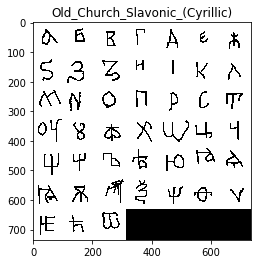

Number of different characters : 45


In [26]:
print("Test alphabets : "+str([alphabet.name for alphabet in alphabets_test]))
evalute_alphabet = alphabets_test[13]
evalute_alphabet.display()

accuracy = 95.750%
Confusion matrix, without normalization


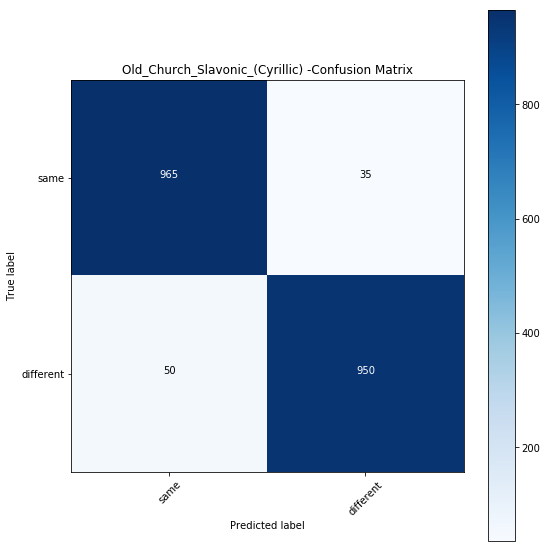

In [27]:
T,Y = evaluate_language(siamese_model,alphabet=evalute_alphabet,size  = 2000,load_image=False)

## One-Shot Classfication

After I built the distance machine (siamese network), I can evaluate the classifications of unseen alphabets with the one-shot technique.


split unseening alphabets's data to train and test

In [28]:
from sklearn.model_selection import train_test_split

X, Y = evalute_alphabet.create_chars_dataset(load_images=False)
#init images for machine (CNN)
X = np.array([init_image(img,input_shape) for img in X])
#split test and train charaters
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7, random_state=1, stratify=Y)

### K Nearest Neighbors Classiffication

This technique uses a relatively small amount of data as "training data." The training data acts as an anchor through it classifying the new data.

The classification is done by examining the distances between the new data and each of the labeled trained data. Then the classifcator choose the N (one or more), nearest neighbors of the new data, and match its label to them (majority determining).

Because the output of the Siamese-Network is one neuron that represents the 'distance' between the inputs and not the 'location' of the image at the space, I need to build a custom made classifier.


![KNN.png](images/KNN.png)

In [29]:
from collections import Counter
class KNeighborsClassifier():
    def __init__(self,model,n_neighbors = 5):
        self.model = model
        self.n_neighbors = n_neighbors
    
    def distances(self,x1,x2):
        X = [x1,x2]
        distances = self.model.predict(X)
        return distances
    
    def fit(self,x,y):
        self.Y = y
        self.X = x
        
    def predict(self,x):
        distances = []
        for x_ii in x:
            xx = [x_ii for ii in range(self.X.shape[0]) ]
            distances.append(self.distances(self.X,np.array(xx)))                            
        
        predicted = []
        for distances_x in distances:
            distances_x =distances_x.flatten()            
            n_mins_idx = np.argpartition(distances_x, self.n_neighbors-1)[:self.n_neighbors]
            n_mins_values = distances_x[n_mins_idx]
            n_mins_classes = self.Y[n_mins_idx]
            counter = Counter(n_mins_classes.flatten())
            most_common_class = counter.most_common(1)
            predicted.append(most_common_class[0][0])
        return np.array(predicted)
            

accuracy = 91.400%
Confusion matrix, without normalization


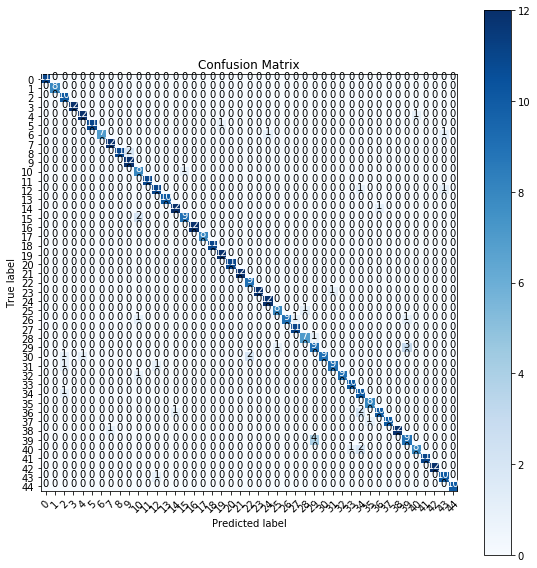

In [30]:
siamese_kneighbors = KNeighborsClassifier(siamese_model)
siamese_kneighbors.fit(X_train,Y_train)
_ = evaluate_classifier(siamese_kneighbors,X_test[0:500],Y_test[0:500])

Note that because this classifier doesn't have the position of the image in space, it needs to calculate the distances of each new unlabeled data with any of the labeled trained data inefficiently.

Classify a lot of data this way can take much time!

#### Extracting Image Location In Space From The Features (Features Vector)

As I have shown, the Siamese-Network successfully handle datasets that it has never seen before. Therefore we can assume that the network has been learned features that can sperate the data.

Because the two siamese inner models (same model but uses twice) have an L1 distance layer after thair outputs, the internal model is forced to generate output vector of the features that clustering the classes.
By using these outputs' vector, we can locate the input's image at the features space map.

In [33]:
siamese_model.layers

In [34]:
inner_model = siamese_model.layers[2] #take the inner model from siamese network

Calculate the location vectors of the data's images using the inner model of the siamese network.

Each vector contains 1000 dimensions that determine the location of the image in the features space (features vector)

In [35]:
train_loc_vector = inner_model.predict(X_train)
test_loc_vector = inner_model.predict(X_test)

#feature vector after siamese network's linear transformation (multiply by the weights)
siamese_dense_w = K.eval(siamese_model.layers[-1].weights[0]).flatten()
train_loc_vector[:] = train_loc_vector[:]*(siamese_dense_w)    
test_loc_vector[:]  = test_loc_vector[:]*(siamese_dense_w)   

#features vectors shape 
train_loc_vector.shape , test_loc_vector.shape

((270, 1000), (630, 1000))

Now I can evaluate the model using a simple k nearest neighbors classifier

accuracy = 93.333%
Confusion matrix, without normalization


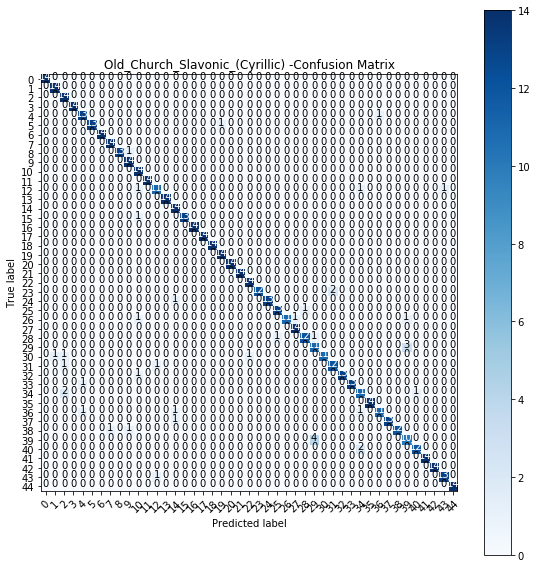

In [36]:
from sklearn.neighbors import KNeighborsClassifier as KNN

classifier_knn = KNN(n_neighbors=3)

classifier_knn.fit(train_loc_vector,Y_train)

_ = evaluate_classifier(classifier_knn,test_loc_vector,Y_test,title=evalute_alphabet.name)

### Using PCA To Decrease Location Vector's Dimensions

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables (entities each of which takes on various numerical values) into a set of values of linearly uncorrelated variables called principal components.

This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component, in turn, has the highest variance possible under the constraint that it is orthogonal to the preceding components

The resulting vectors (each being a linear combination of the variables and containing n observations) are an uncorrelated orthogonal basis set.

Note that PCA is sensitive to the relative scaling of the original variables.

Here I used PCA to reduce the dimensions of the features vector (1000 dimensions) into a small vector (9 dimensions) that contains 99% of the data's variance. The small vector can later be used as an input to other algorithms that benefit from the reduction.

![PCA.png](images/PCA.png)


Number of dimensions after PCA transform is 16, keeping 95.0% variance (before: 1000)
accuracy = 92.540%
Confusion matrix, without normalization


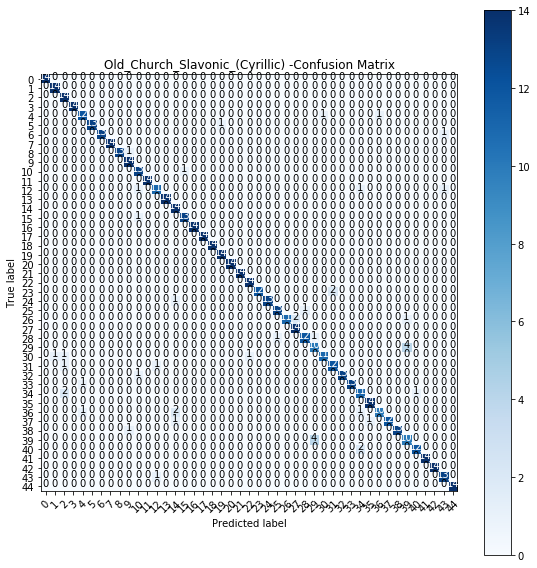

In [37]:
from sklearn.decomposition import PCA
variance_to_keep = .95
num_of_dims = train_loc_vector.shape[-1]

pca = PCA(variance_to_keep)
pca.fit(train_loc_vector)

#transform the huge dimensions location's vector to much smaller one with differnts axises
#each new axises is a linear combination of the originals ones
train_pca = pca.transform(train_loc_vector)
test_pca = pca.transform(test_loc_vector)

classifier_knn = KNN(n_neighbors=3) 

classifier_knn.fit(train_pca,Y_train)

print('Number of dimensions after PCA transform is '+str(test_pca.shape[-1]) +
      ", keeping "+str(variance_to_keep*100) + "% variance (before: "+str(num_of_dims)+")")

_ = evaluate_classifier(classifier_knn,test_pca,Y_test[:],title=evalute_alphabet.name)



Note that with a much smaller vector, we can get almost the same results as the huge first vector.

This technique can easily decrease the complexity of the evaluations.

### K-Means Algorithem For Unsupervised  Learning


After we created the 'machine' that can calculate the locations of input images in the space in a way that separates them commonly by their classes, we can use this machine to handle new alphabets without any labels and try to divide its characters into classes.

K-Mean is a simple unsupervised algorithm that split the data into K different clusters according to their location in space.

![KMEANS.png](images/KMEANS.png)


ARI = 0.814


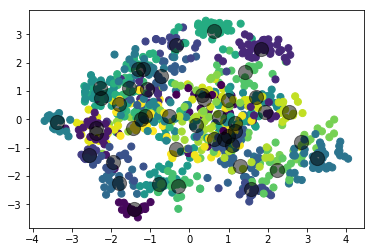

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

#get the number of clusters
n_classes = evalute_alphabet.chars.shape[0]

#unsupervised learning dont use training data
x = inner_model.predict(X)

variance_to_keep = 0.99
pca = PCA(variance_to_keep)

pca.fit(x)

#transform the huge dimensions location's vector to much smaller one with differnts axises
#each new axises is a linear combination of the originals ones
x_pca = pca.transform(x)


kmeans = KMeans(n_clusters=n_classes).fit(x_pca)
kmeans.labels_
centers = kmeans.cluster_centers_

#display the clusters on 2-Dims plot 
plt.scatter(x_pca[:, 0],x_pca[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);


#evaluate the clusters [0,1] ,0 is lowest, 1 highest
ARI = adjusted_rand_score(kmeans.labels_,Y)
print('ARI = ' + format(ARI,".3f"))

alphabet = Old_Church_Slavonic_(Cyrillic)
number of characters = 45


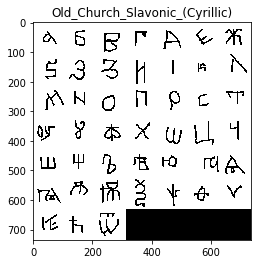

Number of different characters : 45


<Figure size 432x288 with 0 Axes>

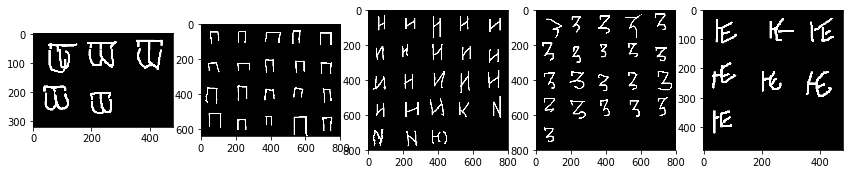

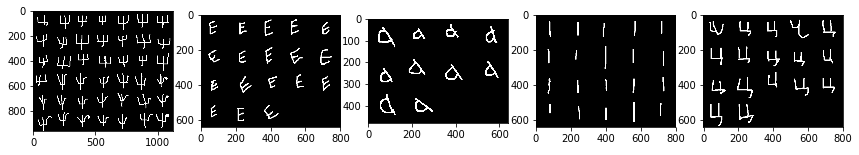

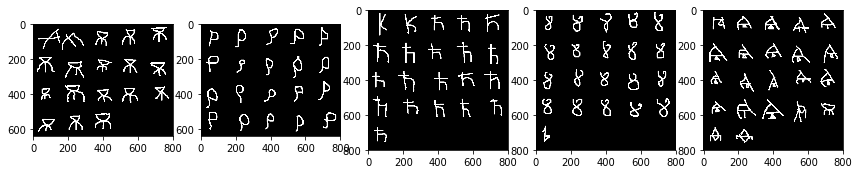

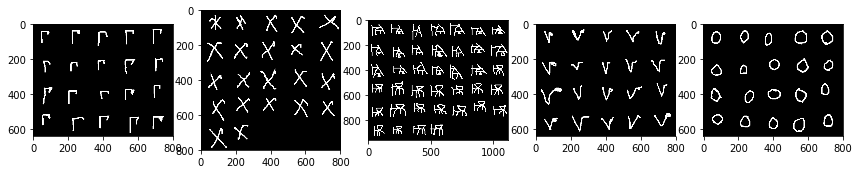

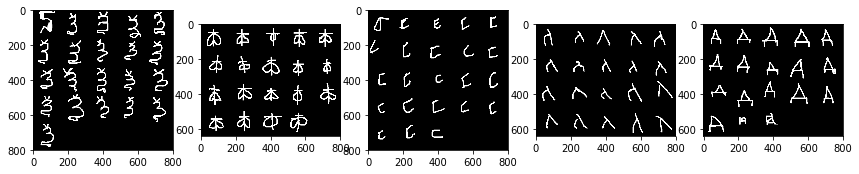

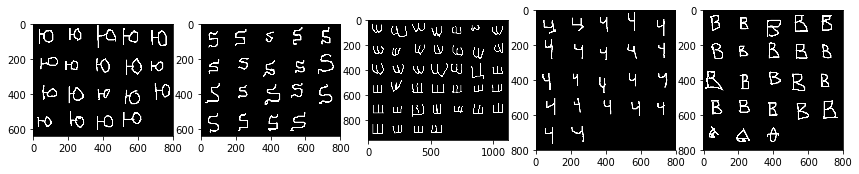

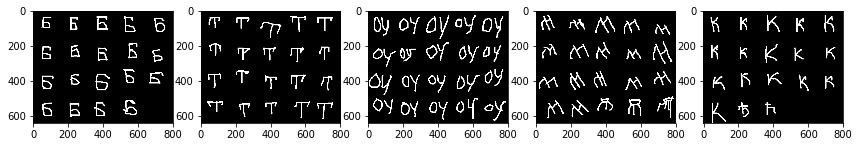

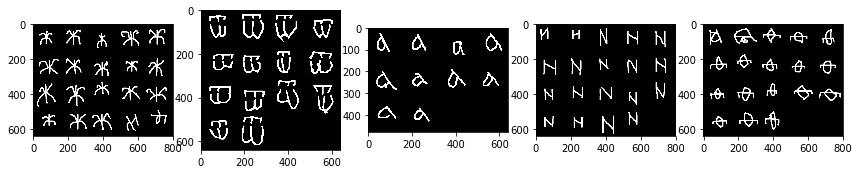

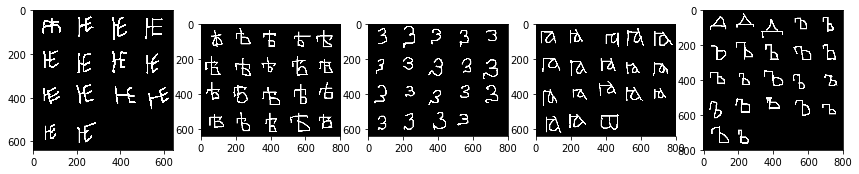

In [39]:
print("alphabet = "+evalute_alphabet.name)
print("number of characters = "+str(evalute_alphabet.chars.shape[0]))

evalute_alphabet.display()

num_of_plot = 5
tmp = kmeans.cluster_centers_.shape[0]%num_of_plot

for cluster in range(kmeans.cluster_centers_.shape[0]):
    if cluster % num_of_plot == 0:
        plt.subplots_adjust(right = 2)
        f, axarr = plt.subplots(1,num_of_plot)
    cluster_x = X[kmeans.labels_ == cluster]
    ax.set_title("cluster "+str(cluster))
    axarr[cluster % num_of_plot].imshow(concat_images(cluster_x)[:,:,0],cmap='gray')
plt.subplots_adjust(right = 2)
plt.show()

# Conclusions

This examination clearly shows that Neural-Networks can be used to handle missions that don't contain enough data for traditional training.

I presented few ways to exploit the supervised learning model and generalizing it to handle other tasks (but still with features-similarity) doing so we can enlarge the variance of the problems that can be resolved by neural networks.

We could improve this technique using ensembling. I didn't demonstrate that because of a lack of memory.

# Investigate the network

In [40]:
def show_features_at(layer_name, image, lines=4, images_per_line=8):
    tmp_model = Model(inner_model.inputs, inner_model.get_layer(layer_name).output)
    features = tmp_model.predict(np.array([image]))
    print(features.shape)
    plt.figure(figsize=[40, 20])
    for index in range(lines * images_per_line):
        plt.subplot(lines, images_per_line, index+1)
        plt.imshow(features[0,:,:,index], cmap='gray')
    plt.show()

conv_pw_1_relu
(1, 80, 80, 64)


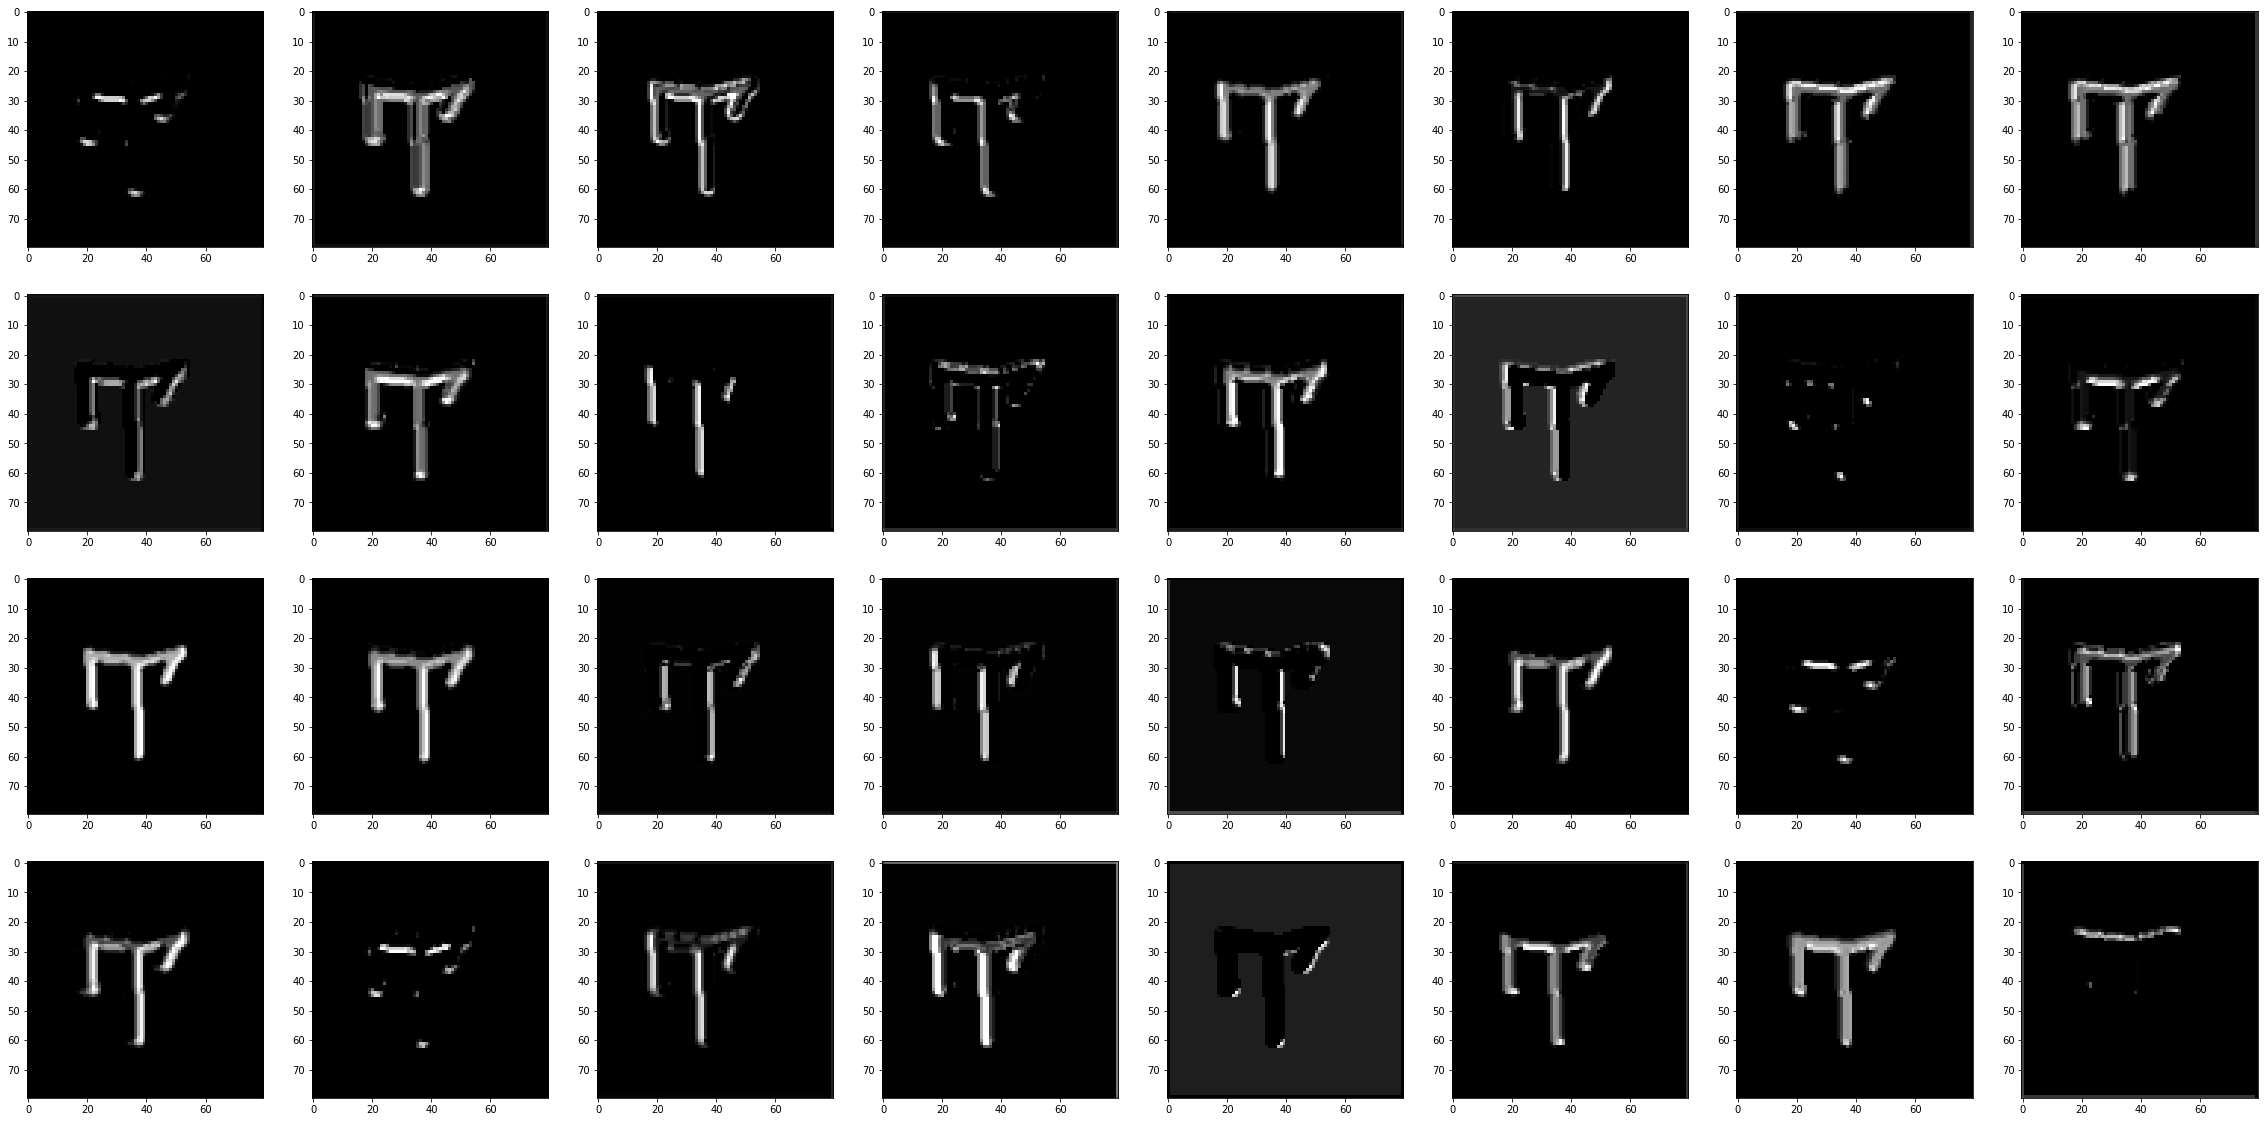

conv_pw_2_relu
(1, 40, 40, 128)


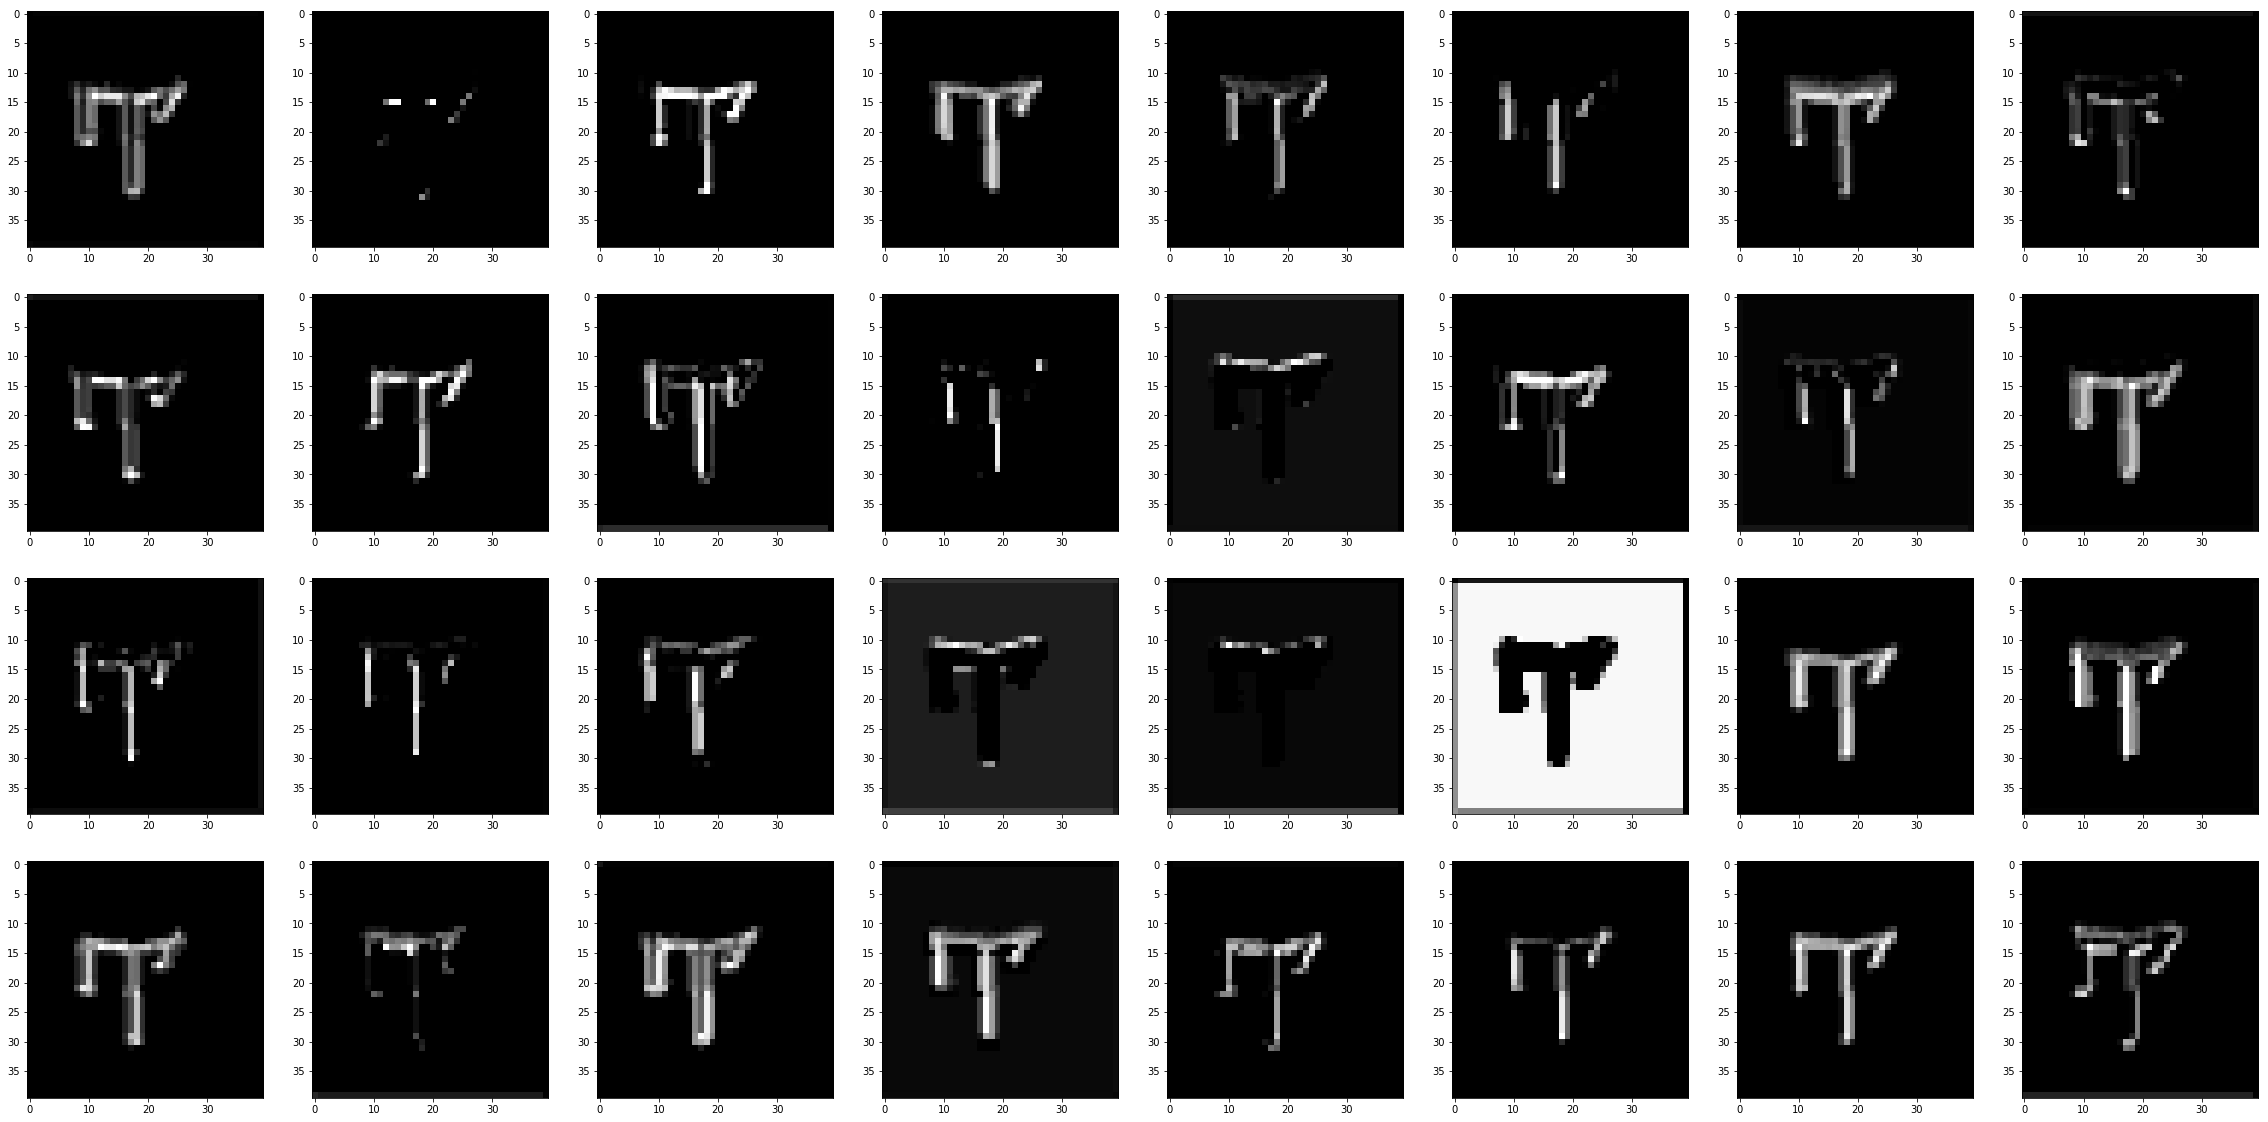

conv_pw_3_relu
(1, 40, 40, 128)


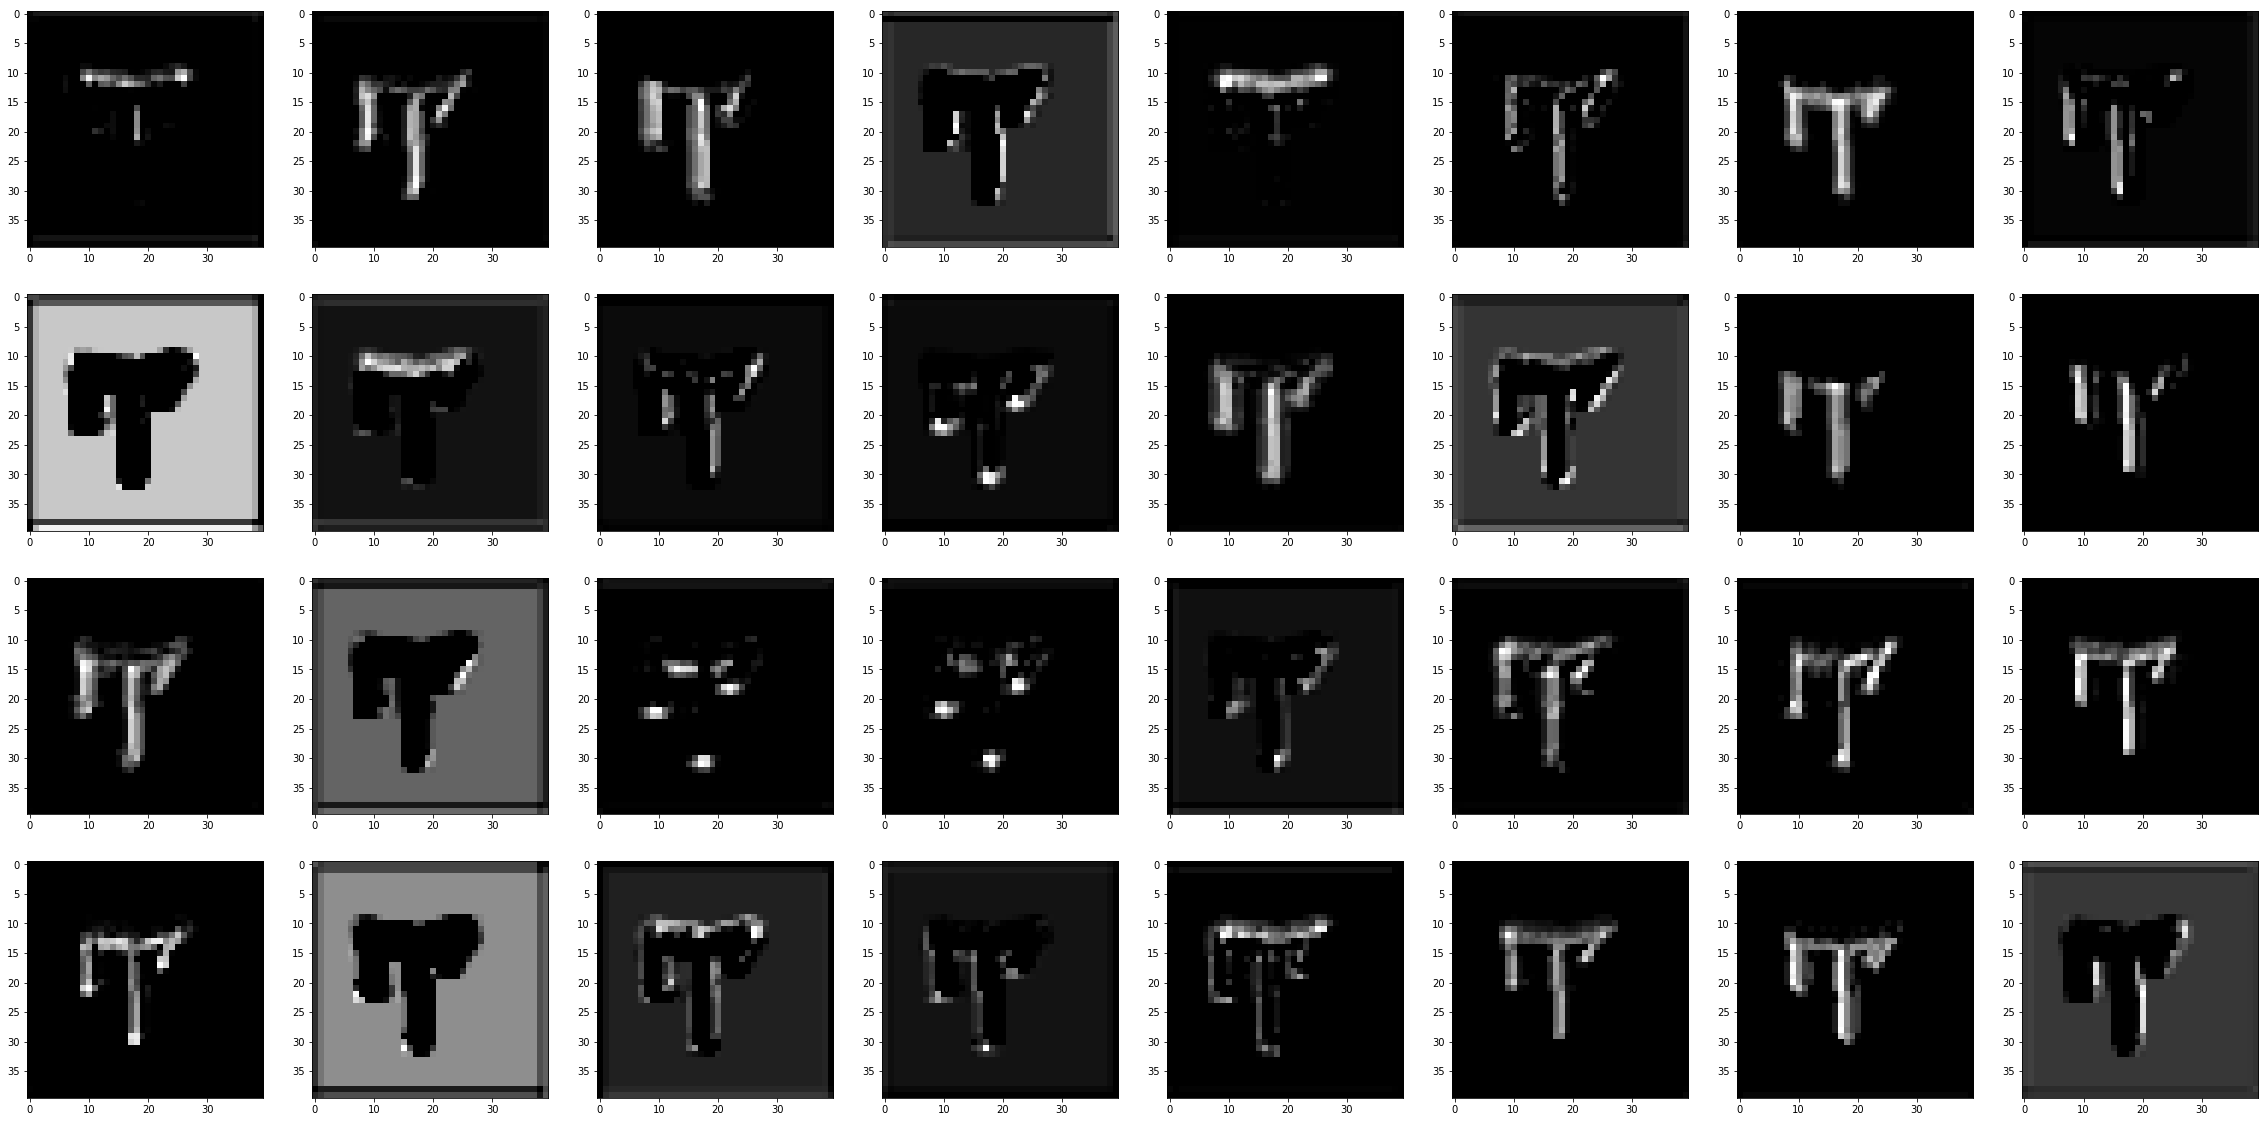

conv_pw_4_relu
(1, 20, 20, 256)


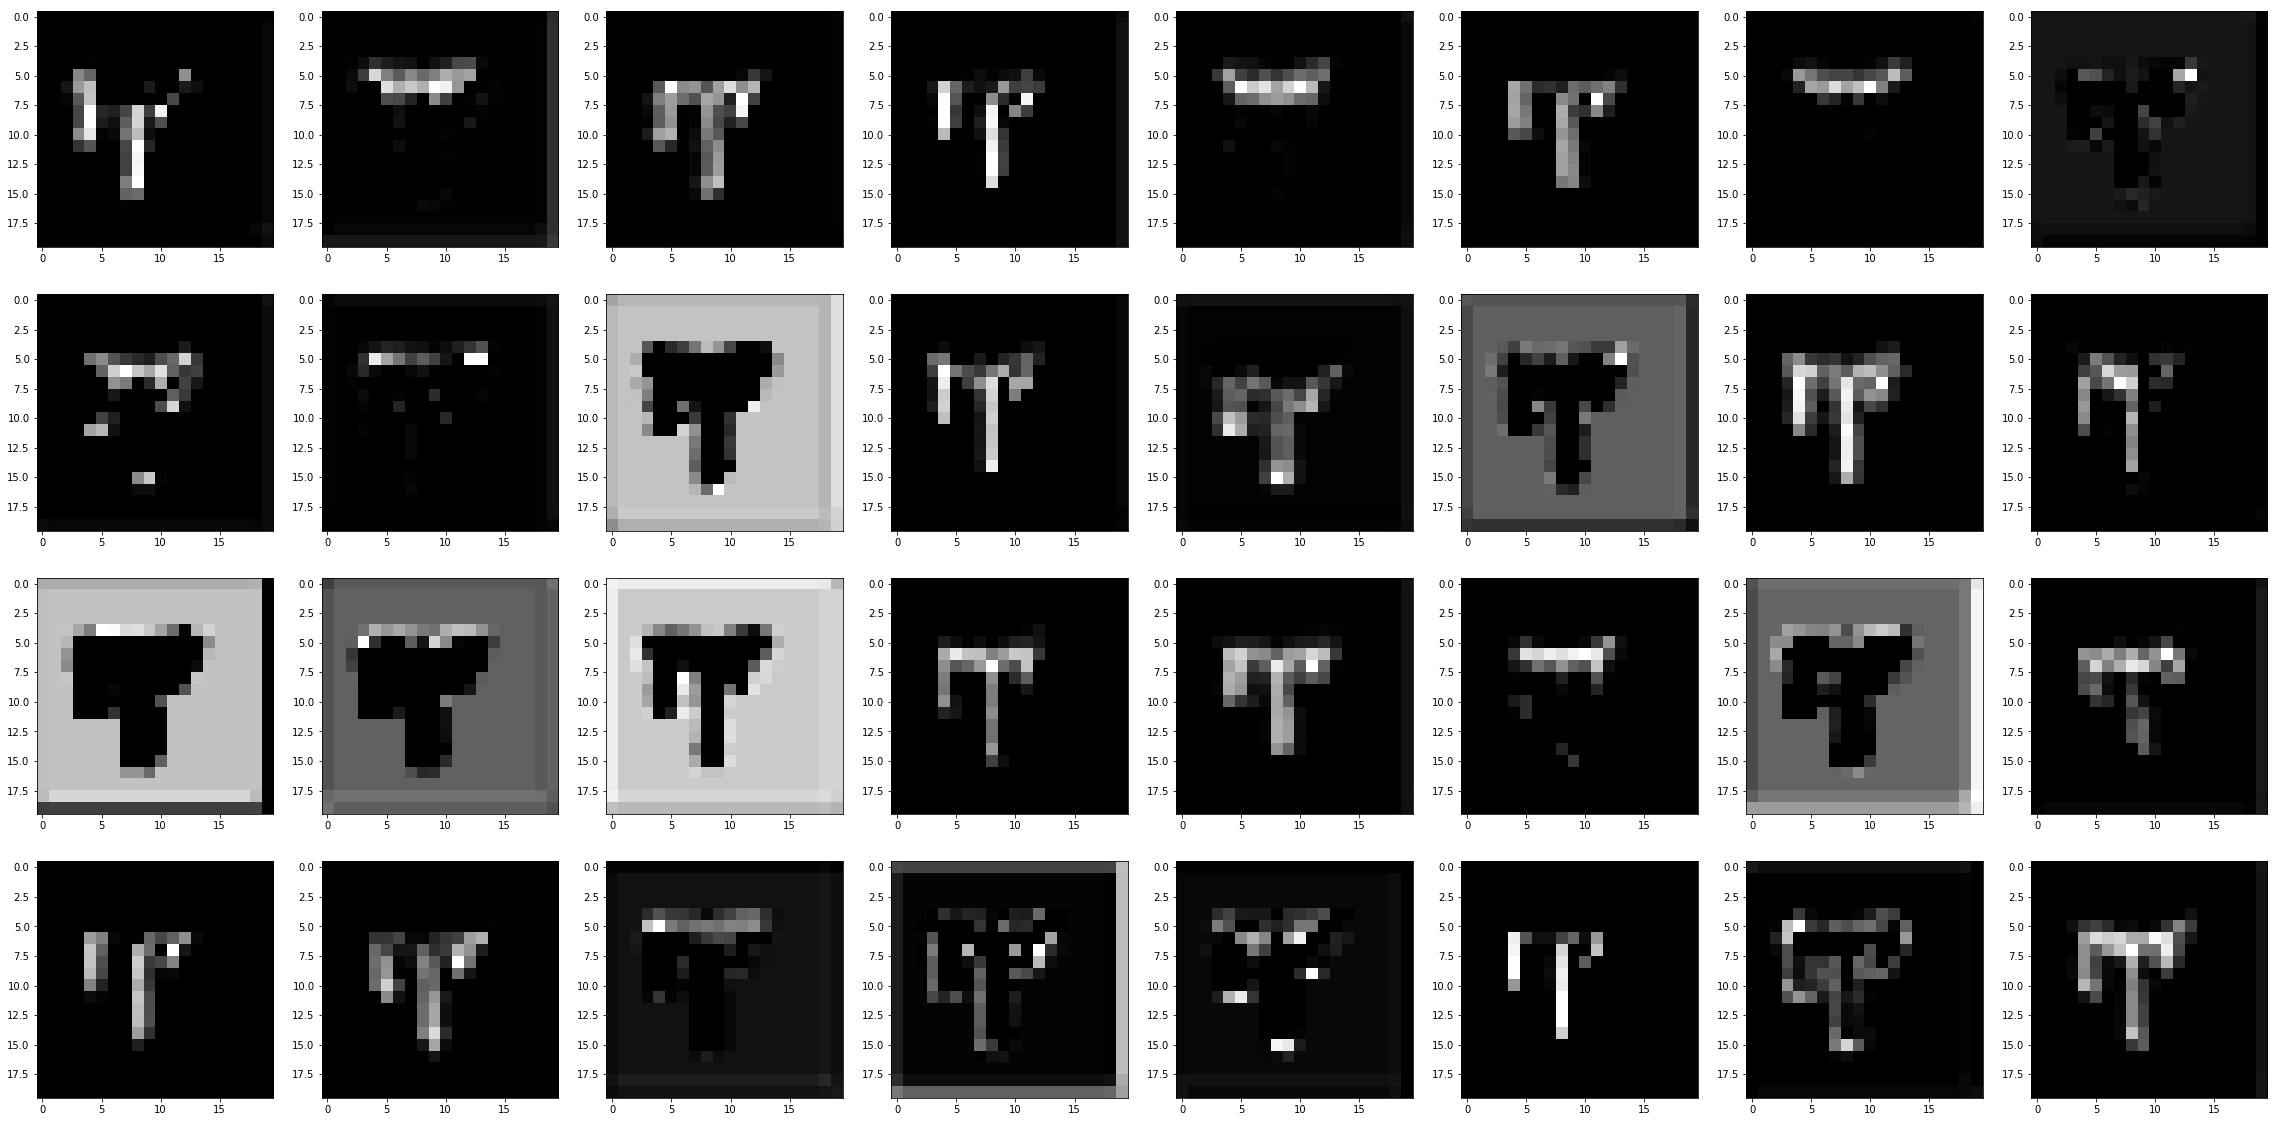

conv_pw_5_relu
(1, 20, 20, 256)


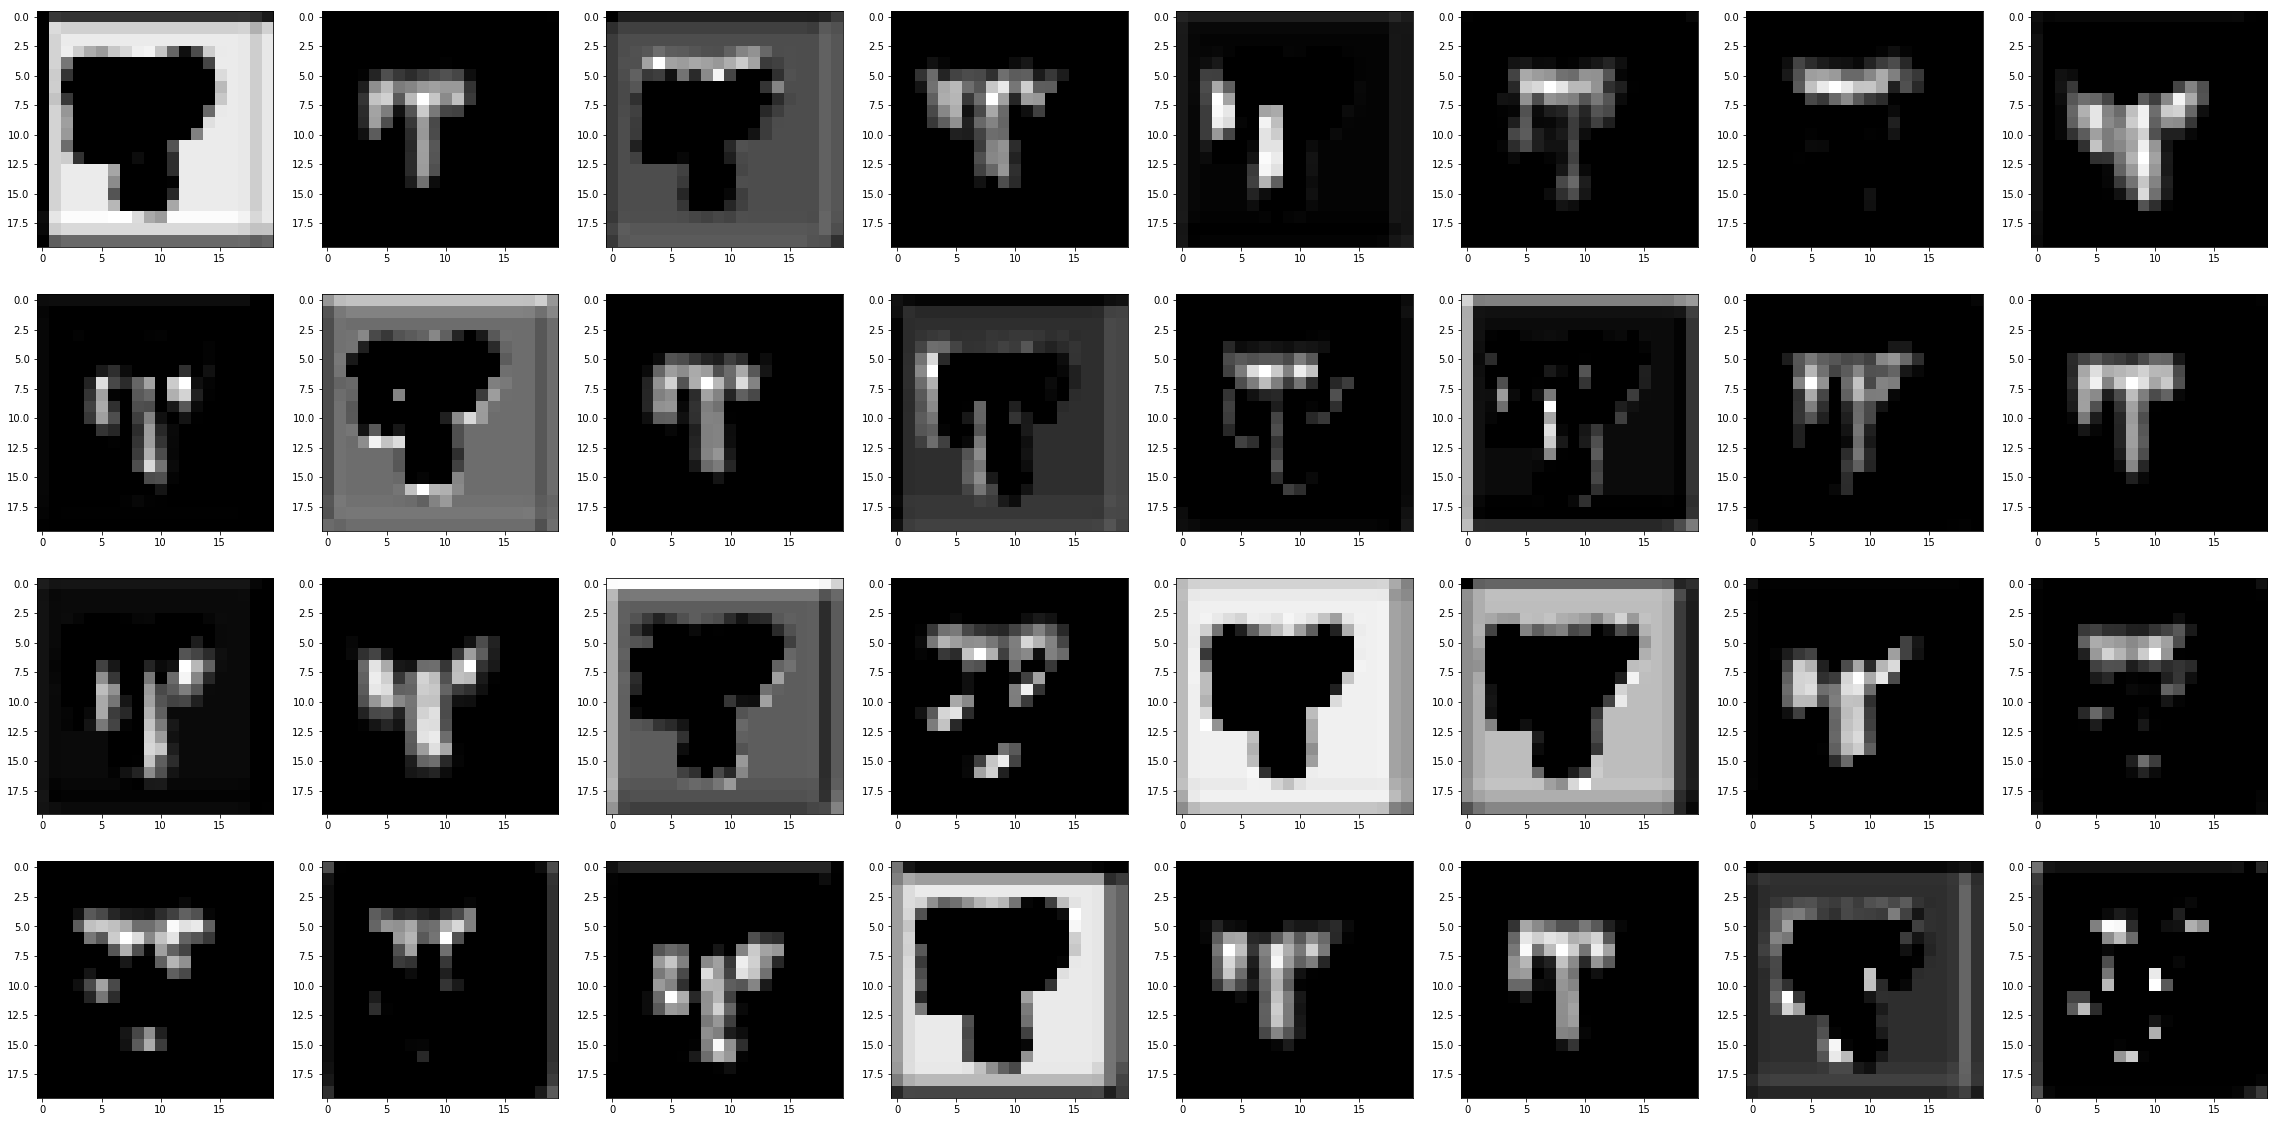

conv_pw_6_relu
(1, 10, 10, 512)


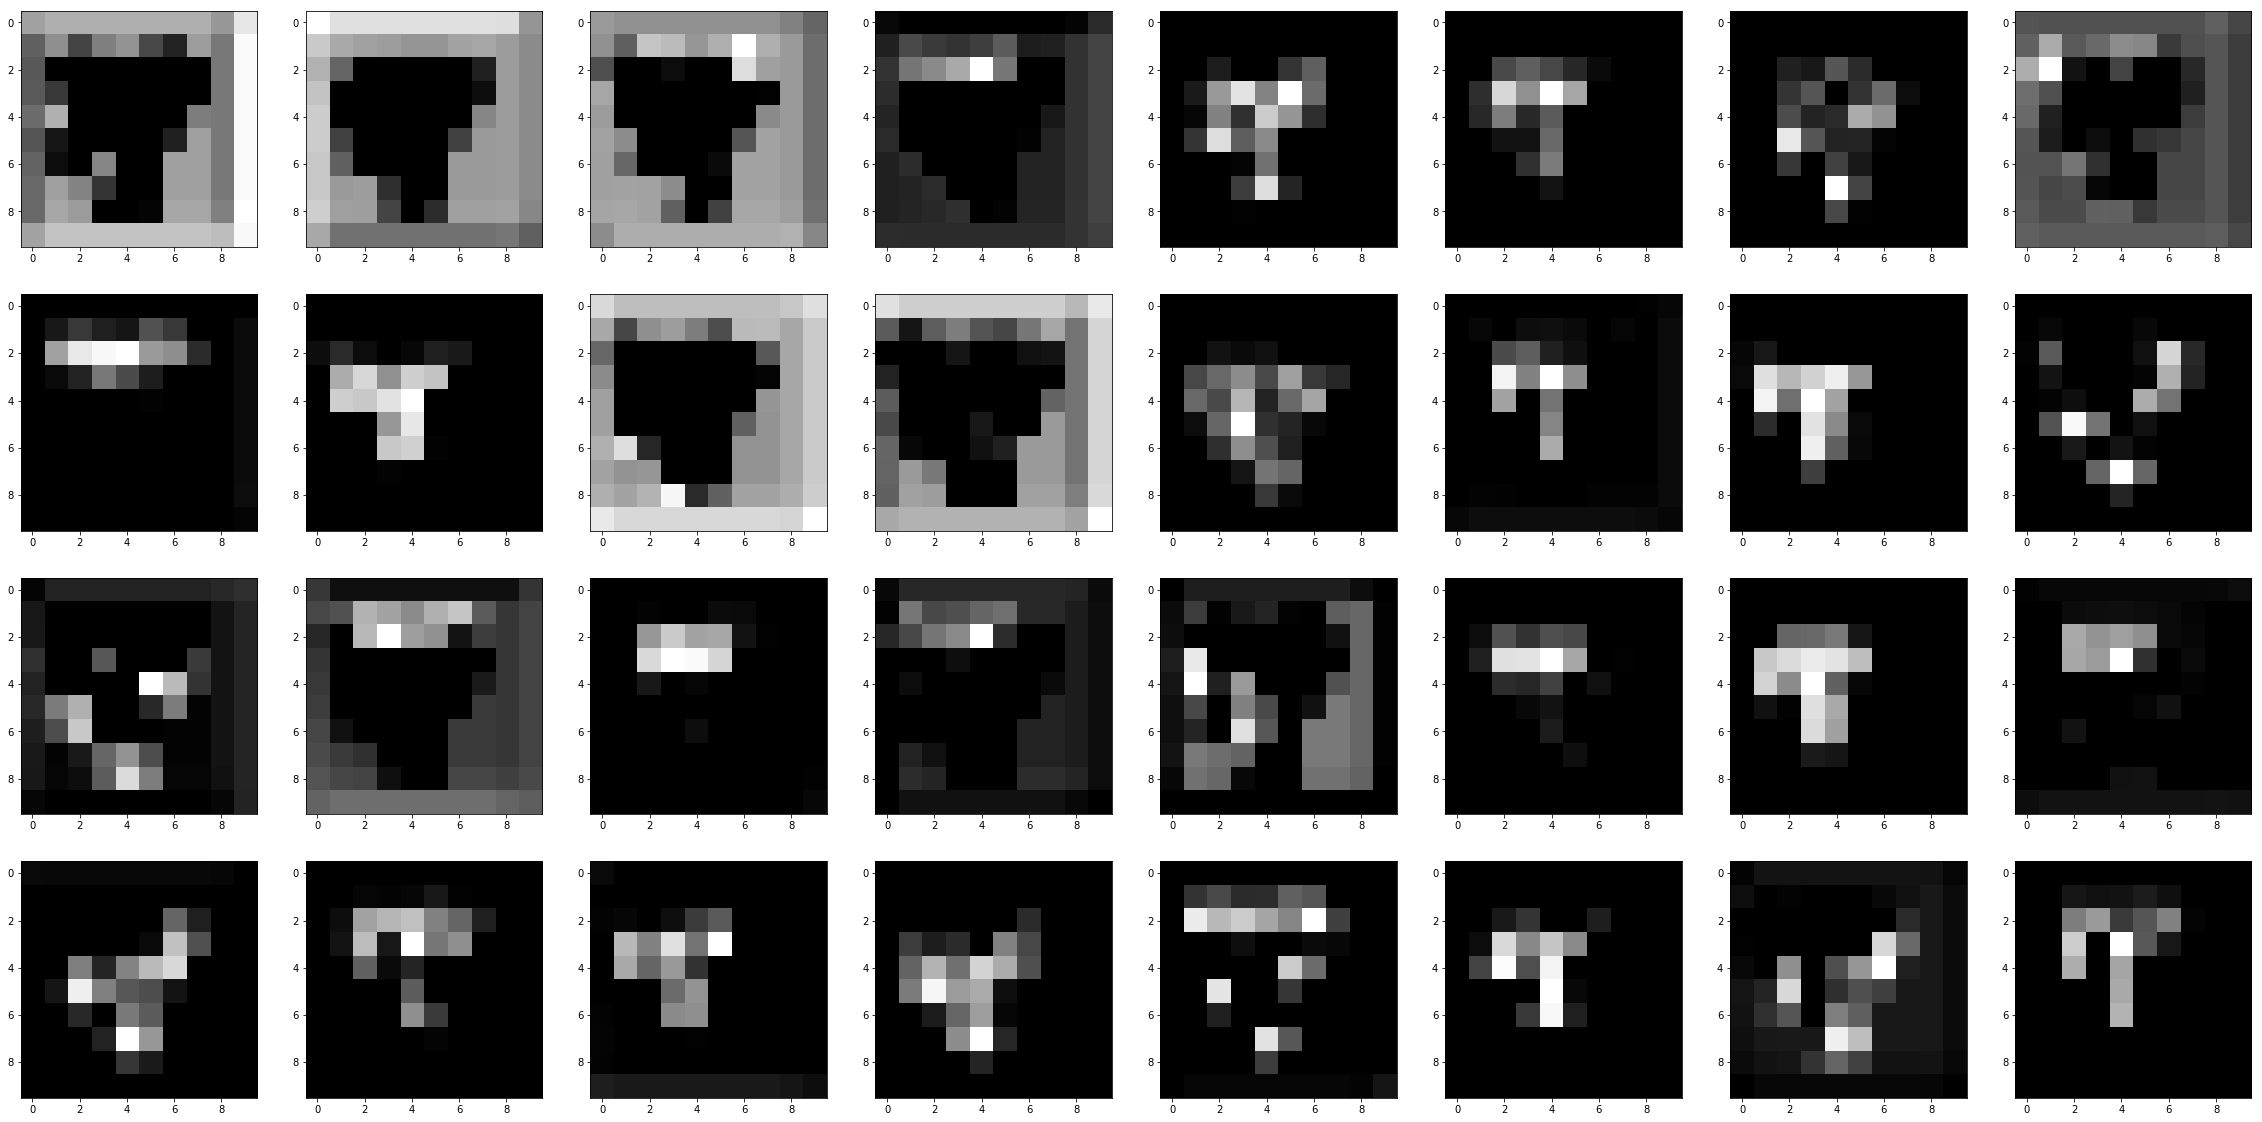

conv_pw_7_relu
(1, 10, 10, 512)


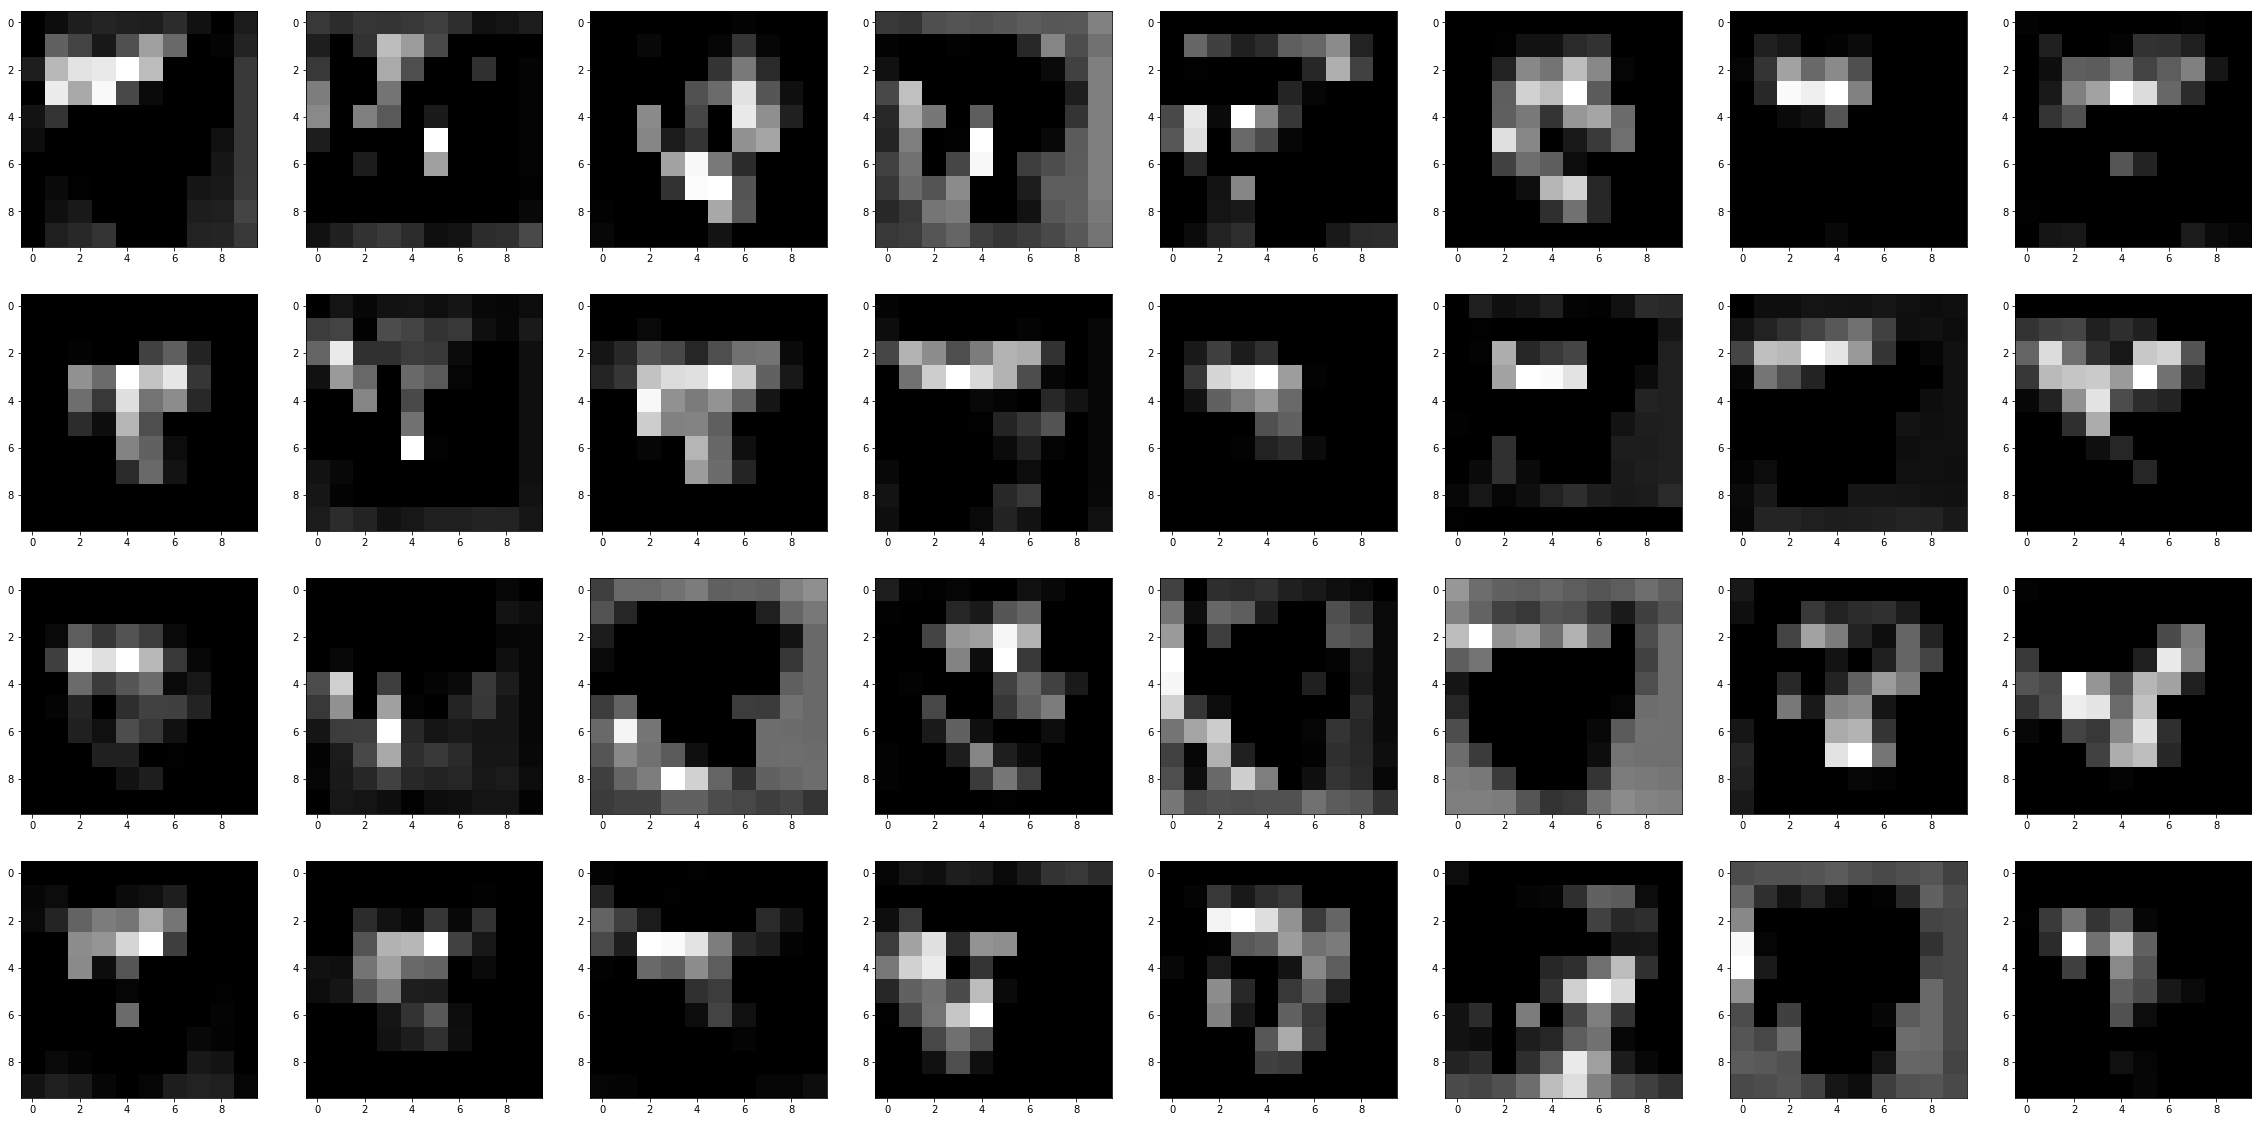

conv_pw_8_relu
(1, 10, 10, 512)


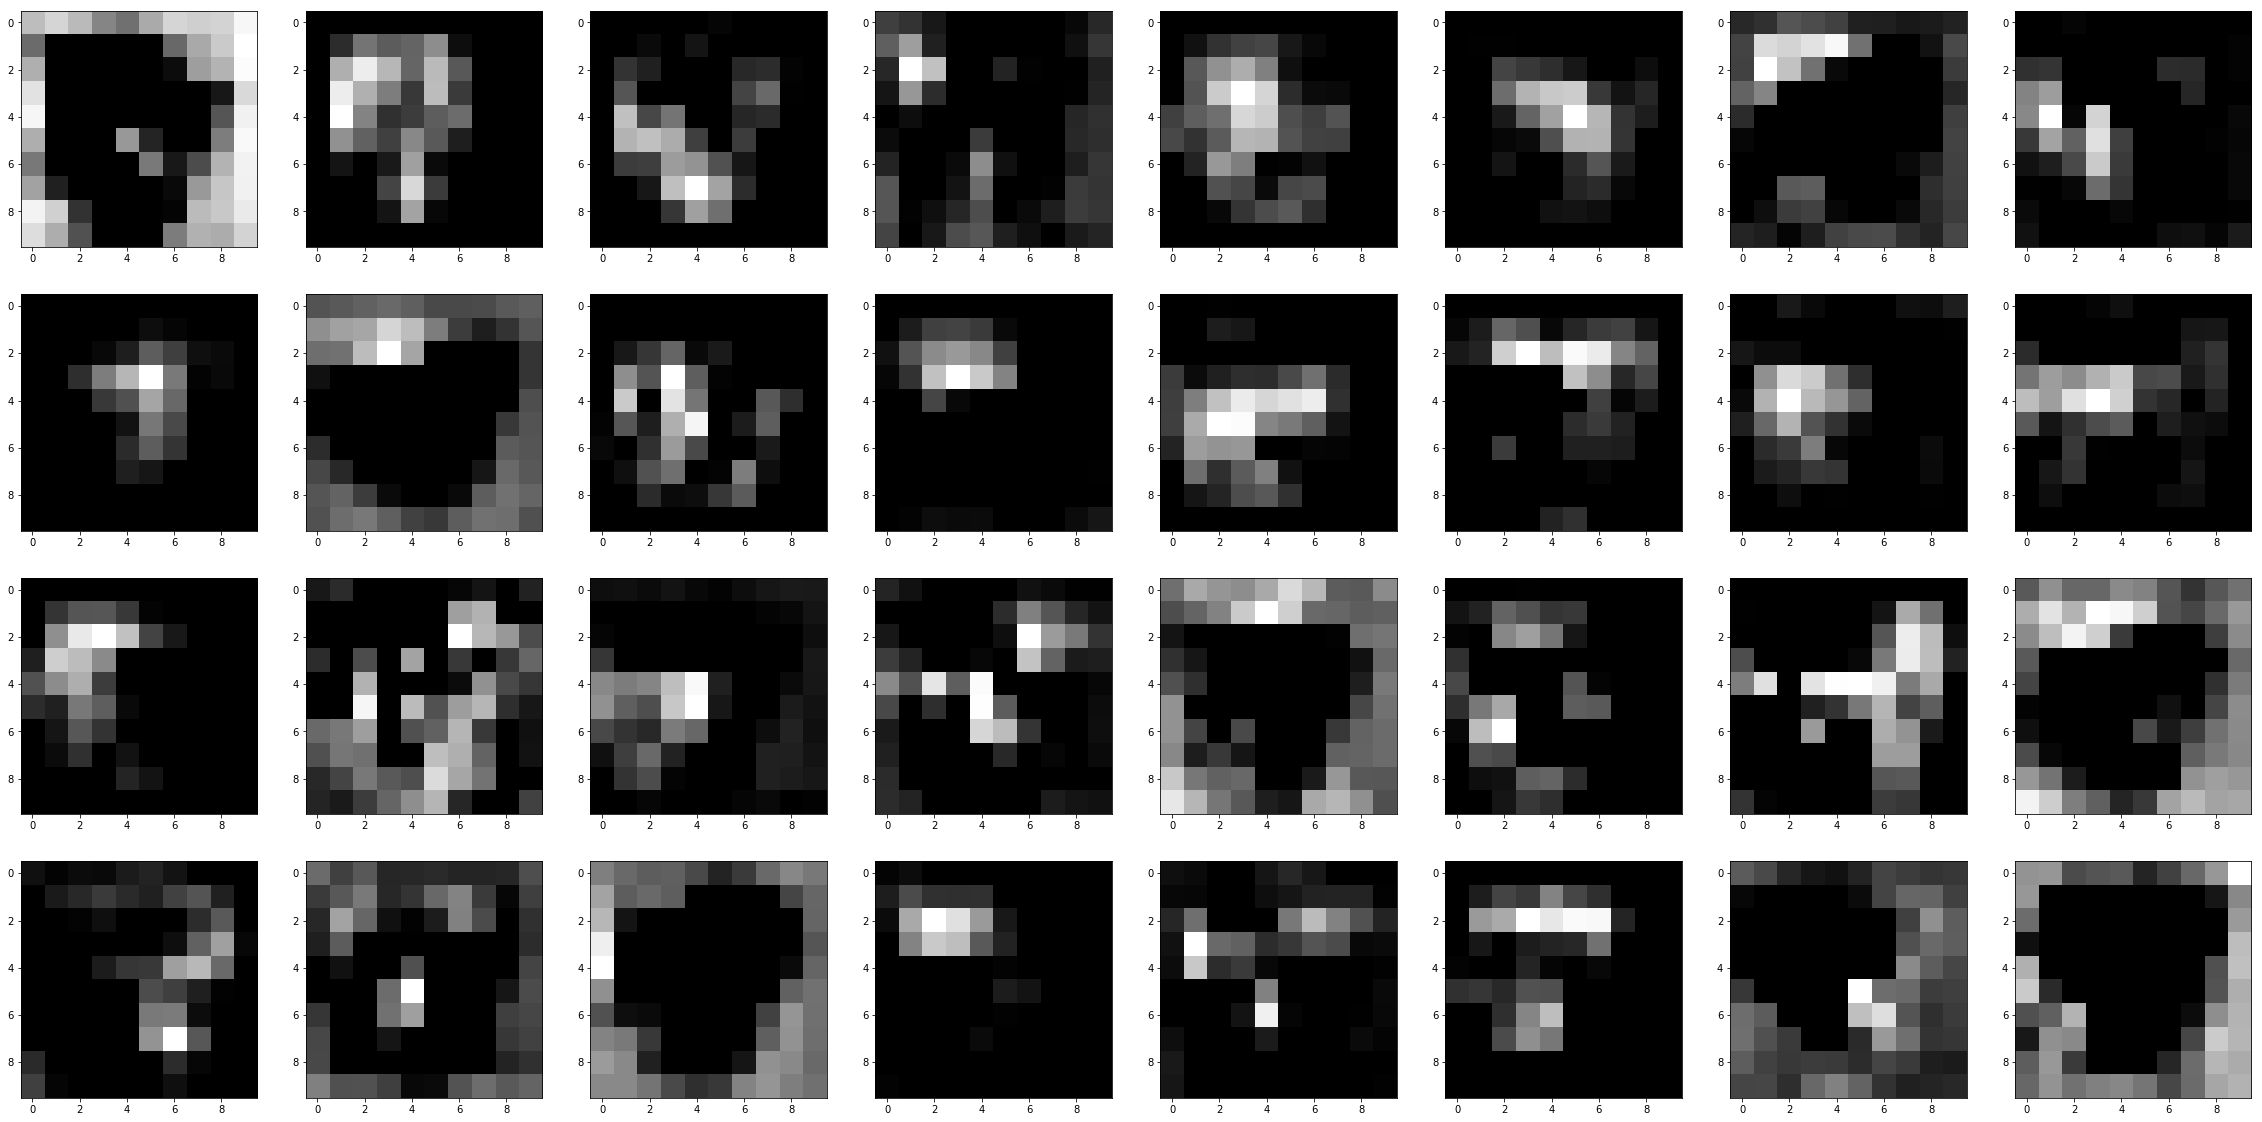

conv_pw_9_relu
(1, 10, 10, 512)


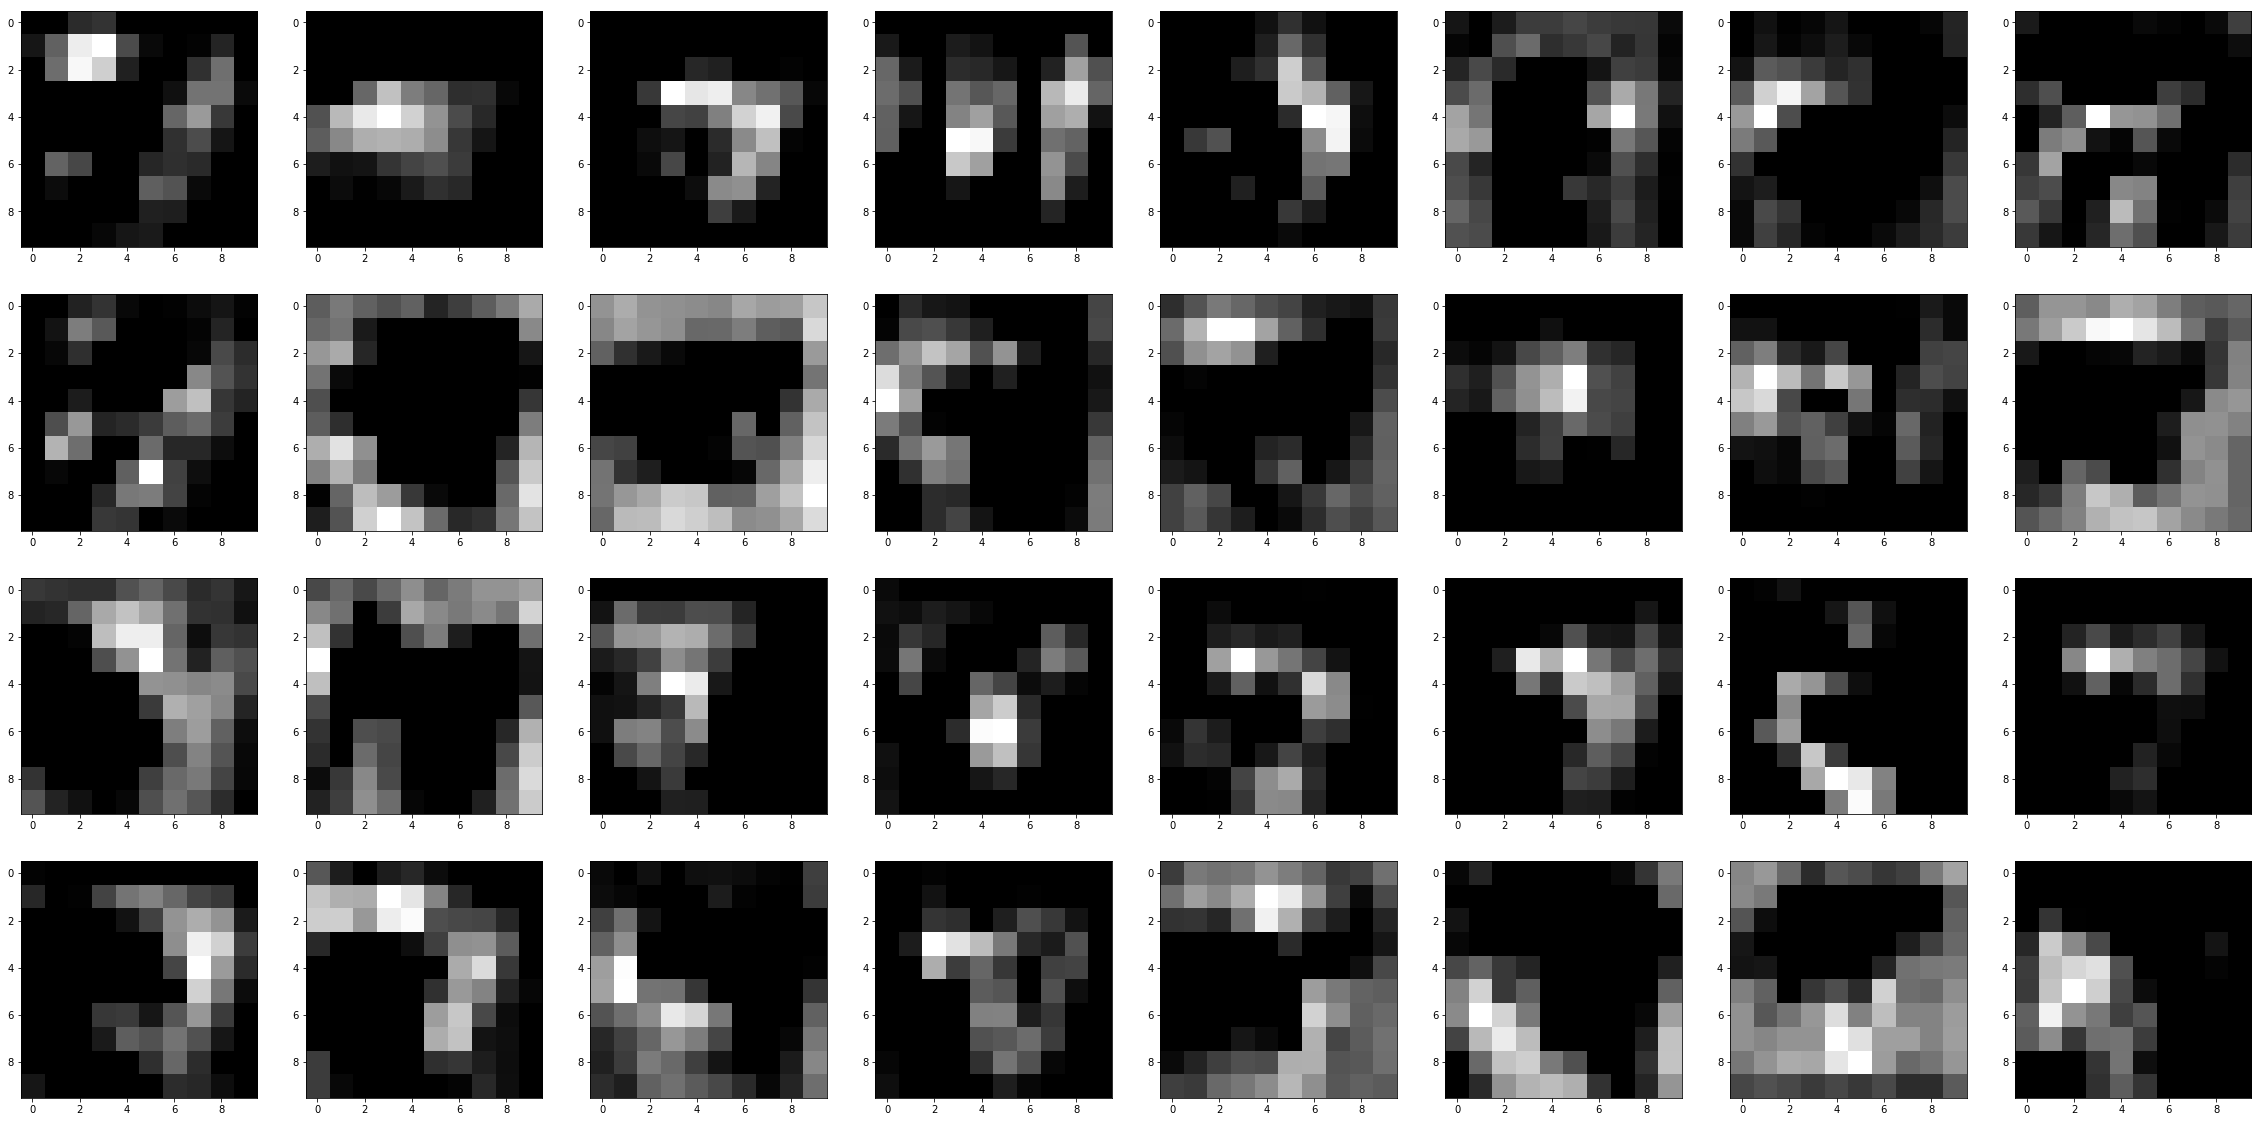

conv_pw_10_relu
(1, 10, 10, 512)


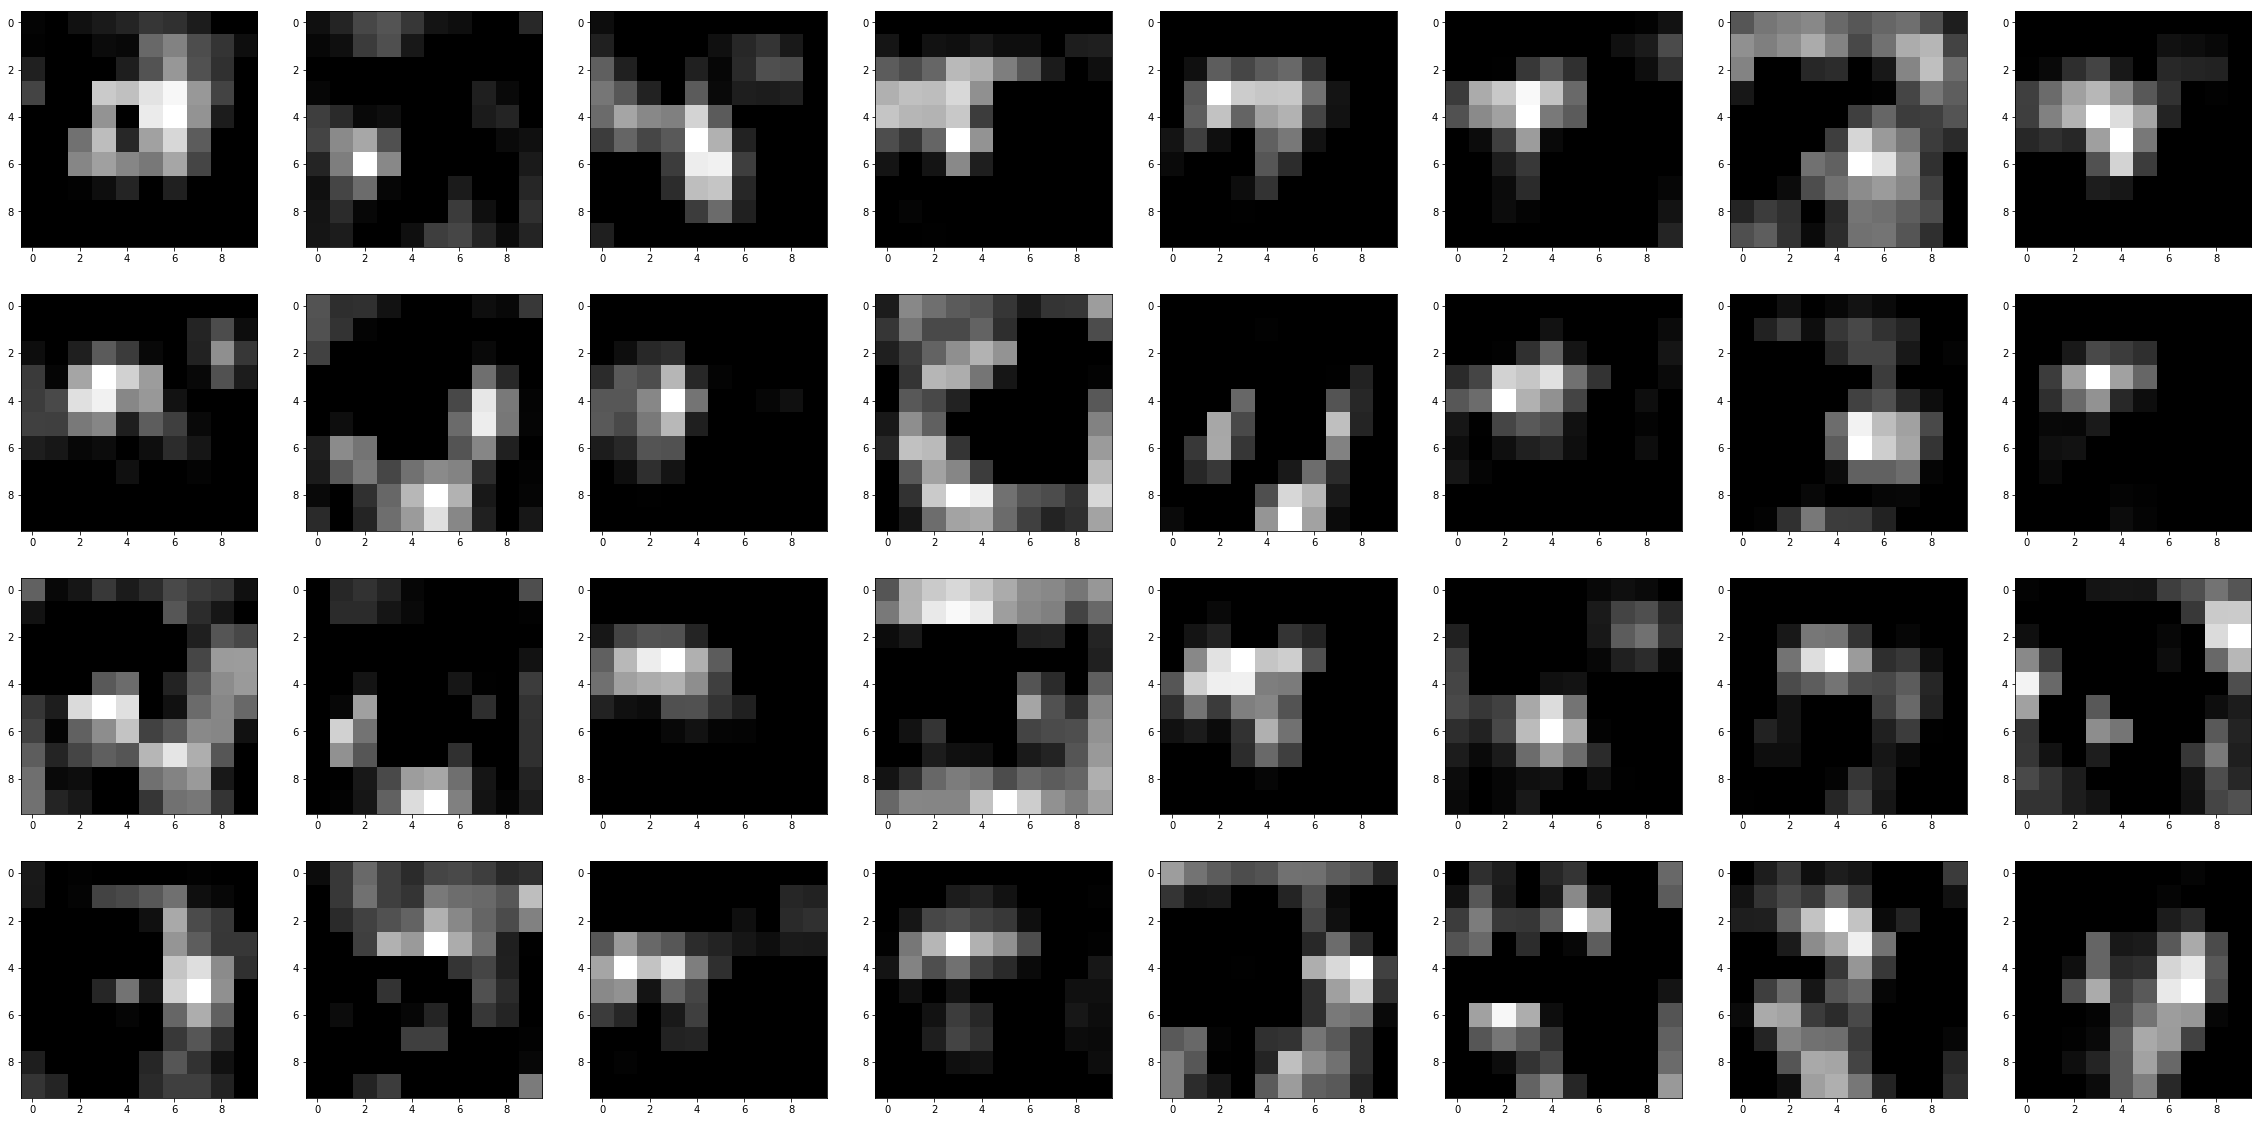

conv_pw_11_relu
(1, 10, 10, 512)


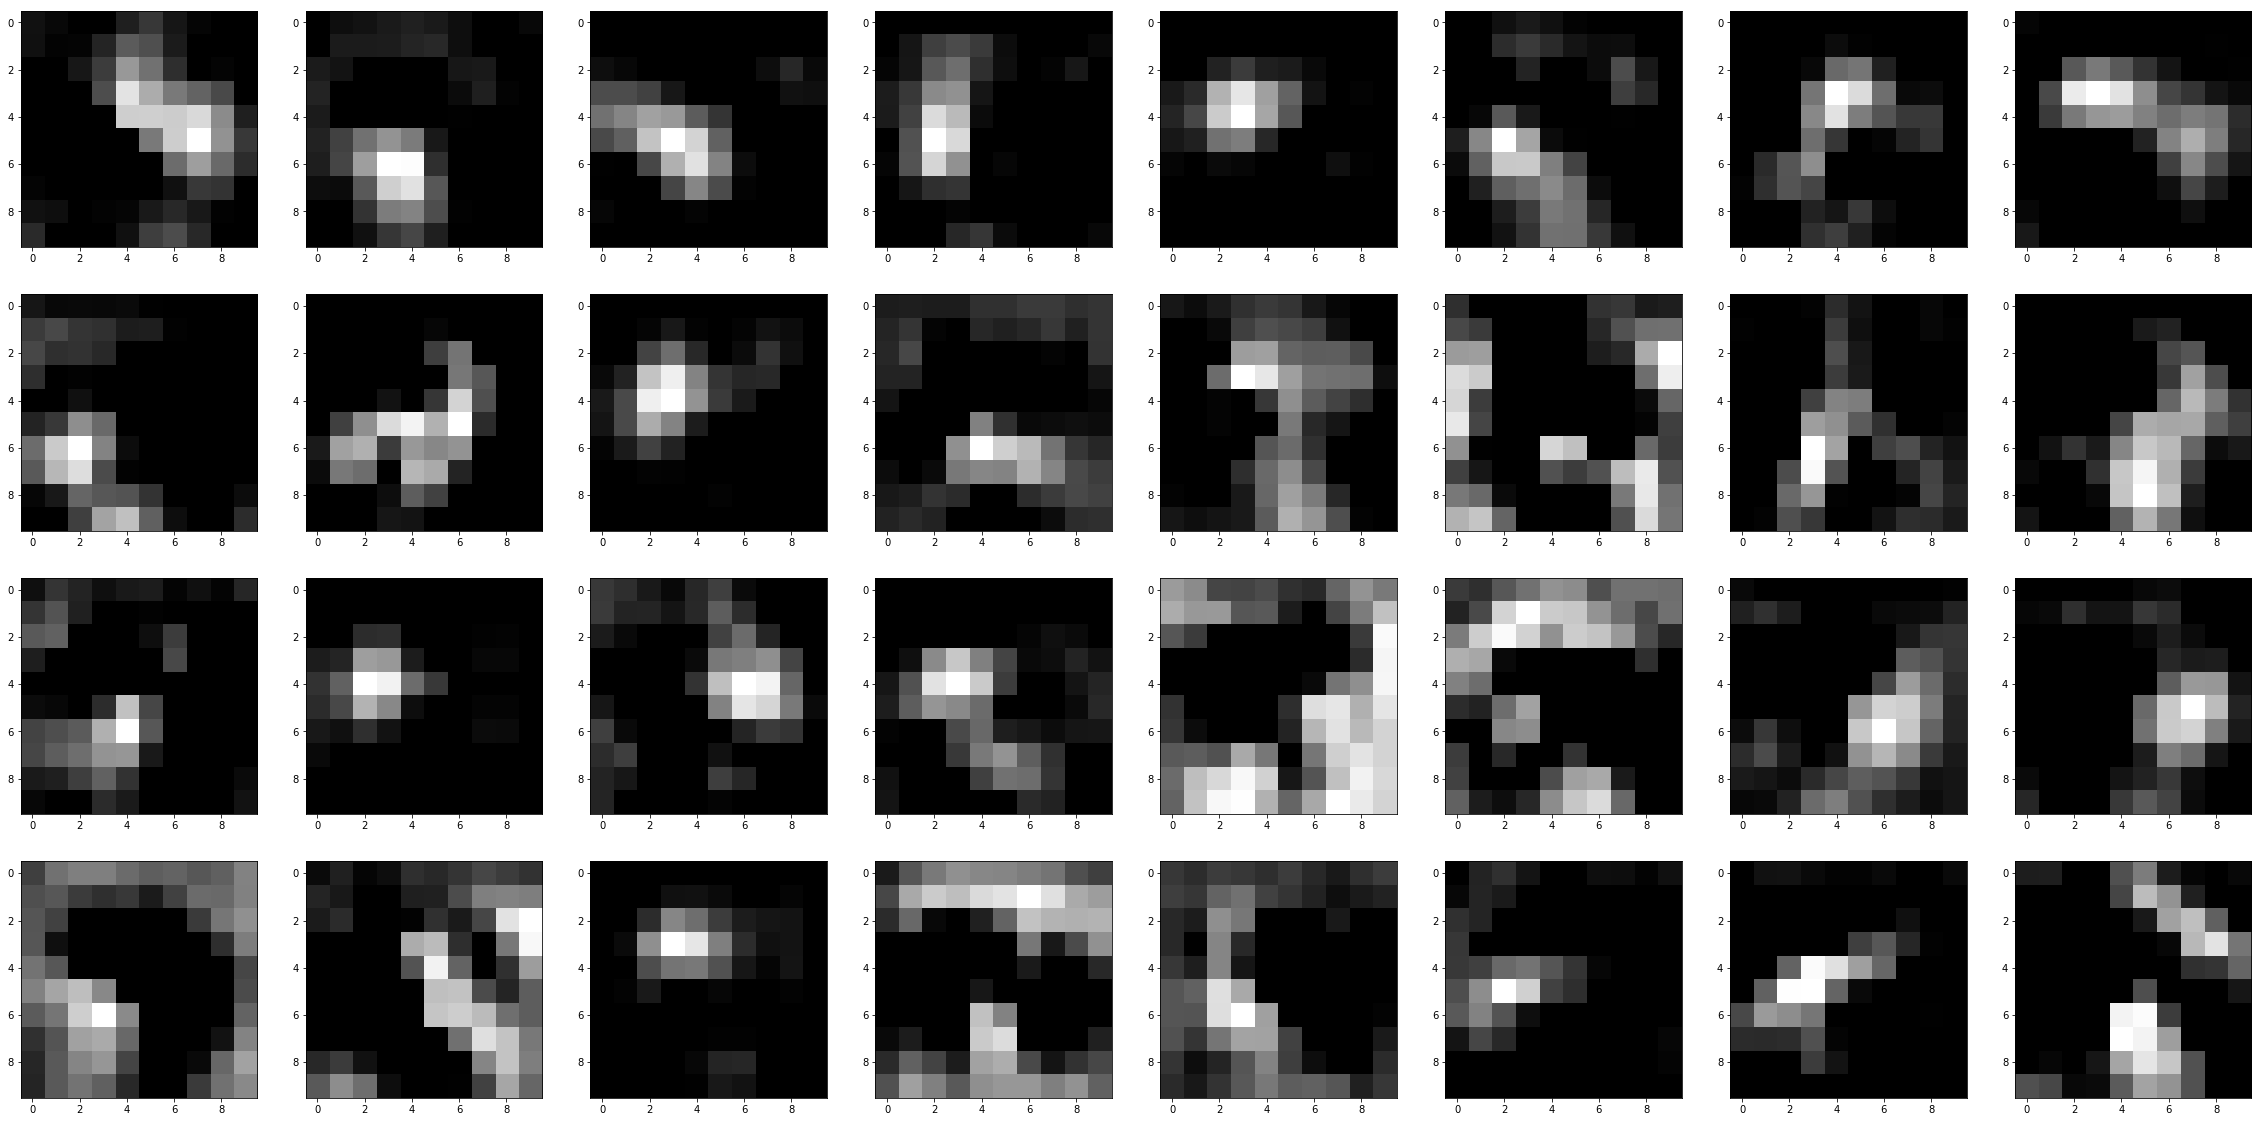

conv_pw_12_relu
(1, 5, 5, 1024)


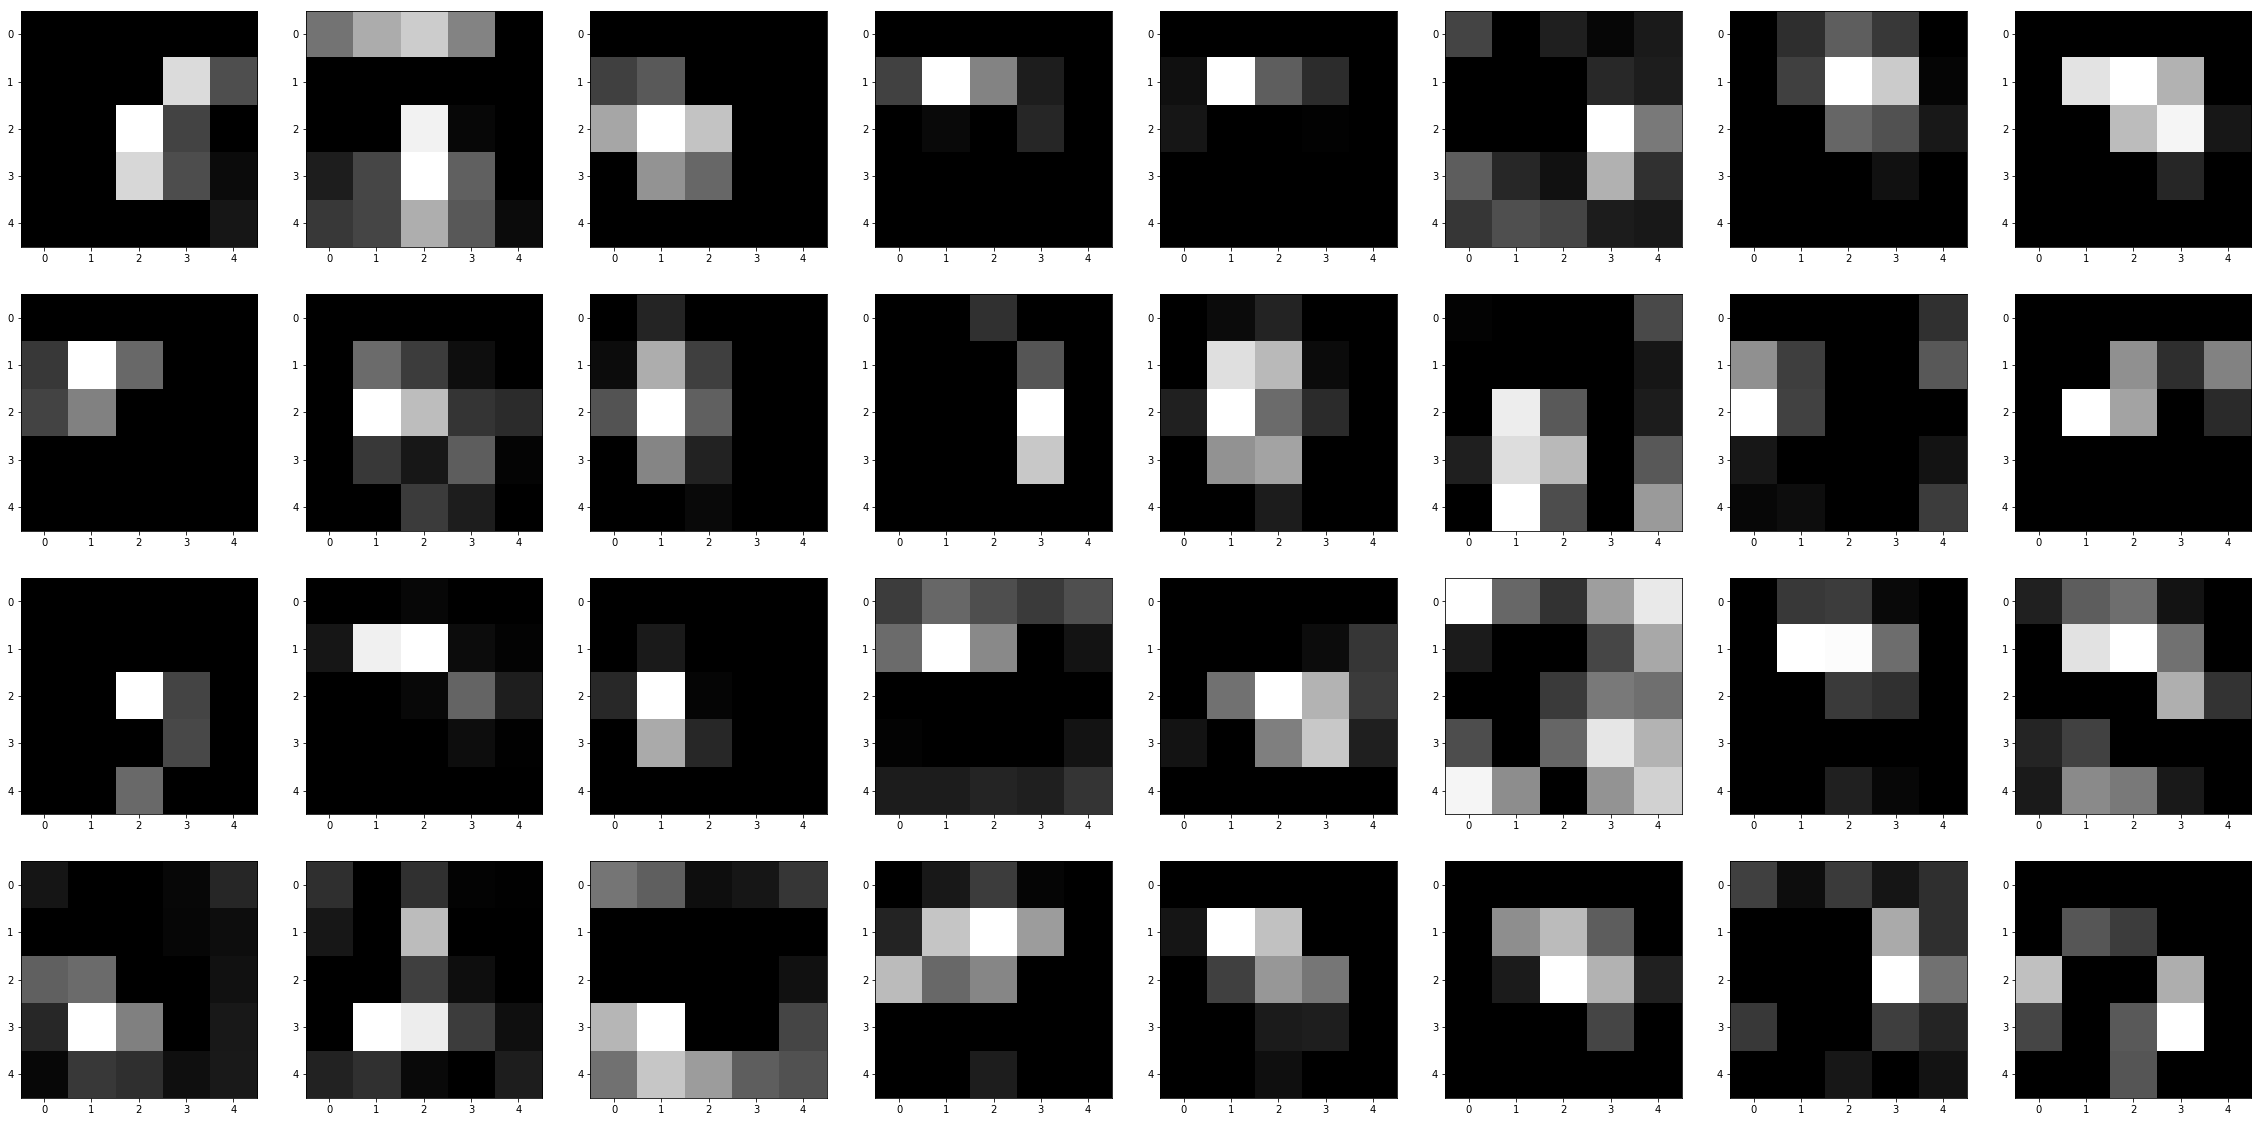

conv_pw_13_relu
(1, 5, 5, 1024)


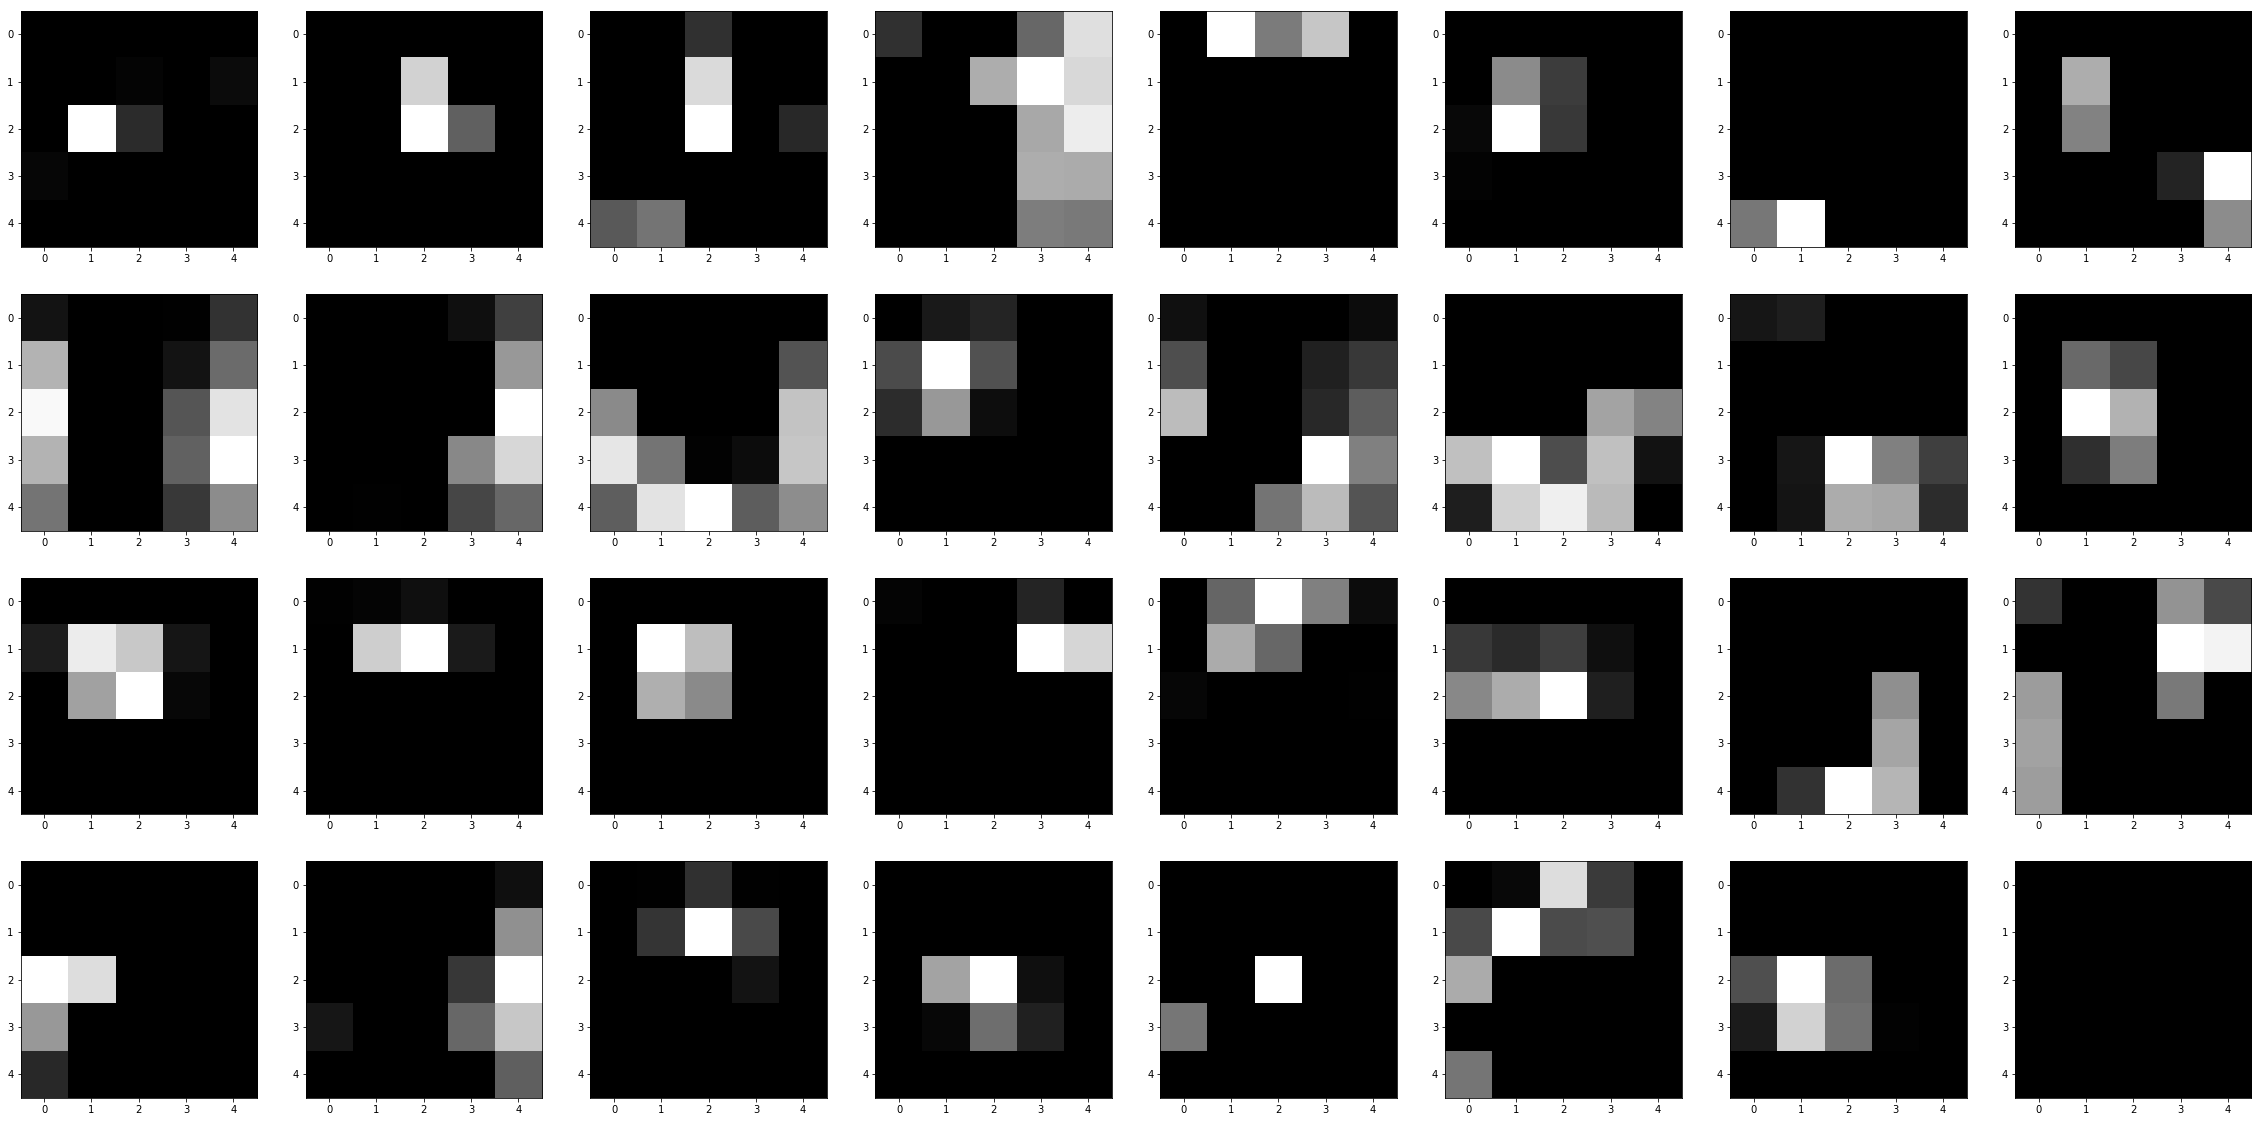

In [41]:
image = X_train[0]
for layer in inner_model.layers:
    if 'conv_pw_' in layer.name and 'relu' in layer.name:
        print(layer.name)
        show_features_at(layer.name, image)

The output shape of the convolutional layer will be [batch_size, number of filters, width, height]
So we can take the average in the width/height axes (2, 3)

In [42]:
batch_size = 3
print('features maps to visualize [batch_size ,f_hight ,f_widh ,num_of_conv_feature]')
conv_features_map = Model(inner_model.inputs, inner_model.get_layer('conv_pw_13_relu').output).predict(X[:batch_size])
print(conv_features_map.shape)

print('avaraged features maps to visualize [batch_size ,f_hight ,f_widh ,num_of_conv_feature]')
avg_conv_features = Model(inner_model.inputs, inner_model.get_layer('reshape_1').output).predict(X[:batch_size])
print(avg_conv_features.shape)

print('features_maps to features vector outputs weights [num_of_conv_features_maps ,features_vector_size]')
features_maps_w = K.eval(inner_model.get_layer('conv_preds').weights[0])[0,0]
print(features_maps_w.shape)

print('features vector to siamese predicted output weights [features_vector_size ,siamese_output_size]')
siamese_dense_w = K.eval(siamese_model.layers[-1].weights[0])
print(siamese_dense_w.shape)

print('\nFeatures_maps rerlative weights [num_of_conv_features_maps ,siamese_output_size]')
for feature_w in range(features_maps_w.shape[-1]):
    features_maps_w[feature_w] = features_maps_w[feature_w] * siamese_dense_w.flatten()
print(features_maps_w.shape)

print('\nRelative influence of the features maps [batch_size ,f_hight ,f_widh, num_of_conv_feature]')
for img in range (conv_features_map.shape[0]):
    for conv_feature in range(conv_features_map.shape[-1]):
        conv_features_map[img][:,:,conv_feature] *= features_maps_w[conv_feature][0] 
        
conv_features_map = conv_features_map.mean(axis=3)
print(conv_features_map.shape)





features maps to visualize [batch_size ,f_hight ,f_widh ,num_of_conv_feature]
(3, 5, 5, 1024)
avaraged features maps to visualize [batch_size ,f_hight ,f_widh ,num_of_conv_feature]
(3, 1, 1, 1024)
features_maps to features vector outputs weights [num_of_conv_features_maps ,features_vector_size]
(1024, 1000)
features vector to siamese predicted output weights [features_vector_size ,siamese_output_size]
(1000, 1)

Features_maps rerlative weights [num_of_conv_features_maps ,siamese_output_size]
(1024, 1000)

Relative influence of the features maps [batch_size ,f_hight ,f_widh, num_of_conv_feature]
(3, 5, 5)


In [43]:
def attention_map(siamese_model, images):
    inner_model = siamese_model.layers[-3]
    siamese_dense_w = K.eval(siamese_model.layers[-1].weights[0]).flatten()
    
    conv_features_map = Model(inner_model.inputs,
                              inner_model.get_layer('conv_pw_13_relu').output).predict(images)

    features_maps_w = K.eval(inner_model.get_layer('conv_preds').weights[0])[0,0]
    
    for feature_w in range(features_maps_w.shape[-1]):
        features_maps_w[feature_w] = features_maps_w[feature_w] * siamese_dense_w
        
    for img in range (conv_features_map.shape[0]):
        for conv_feature in range(conv_features_map.shape[-1]):
            conv_features_map[img][:,:,conv_feature] *= features_maps_w[conv_feature][0]
    
    conv_features_map = conv_features_map.mean(axis=3)
    conv_features_map = [cv2.resize(normalize(feature_map), (images.shape[2], images.shape[1])) for feature_map in conv_features_map]
    return np.array(conv_features_map)**3
       

same | predicted : same


<Figure size 2880x2880 with 0 Axes>

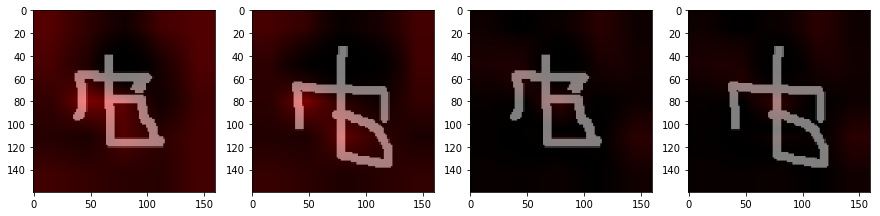

same | predicted : same


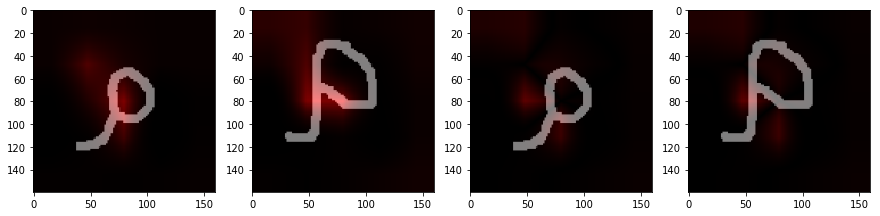

same | predicted : same


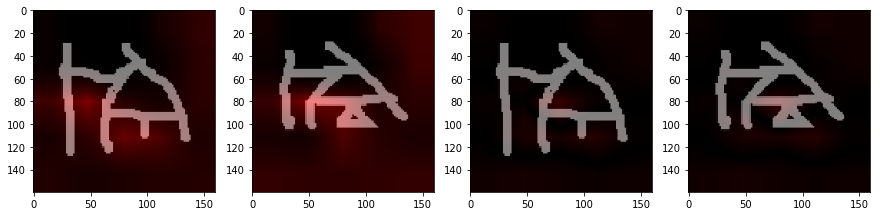

same | predicted : same


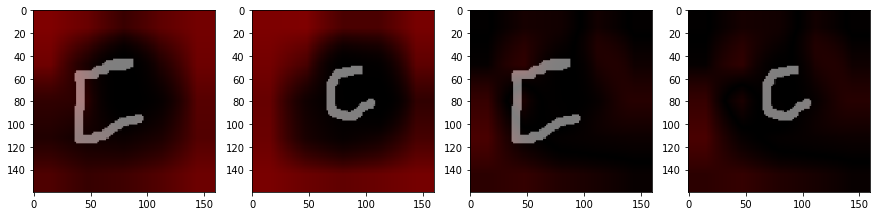

same | predicted : same


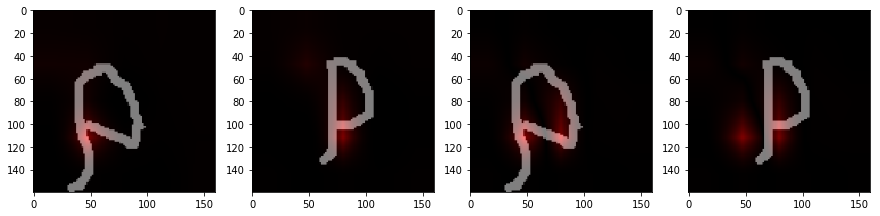

same | predicted : same


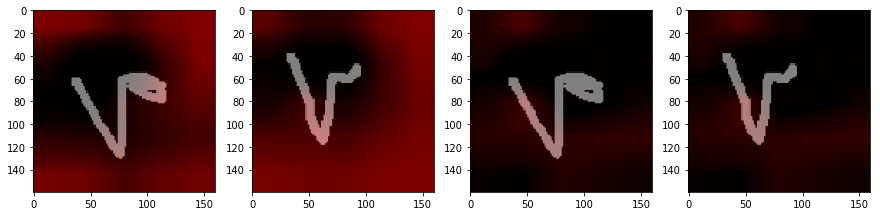

same | predicted : same


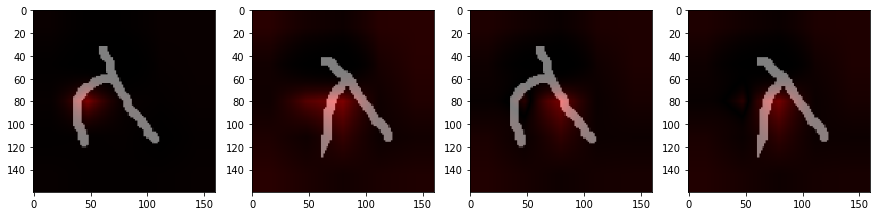

same | predicted : same


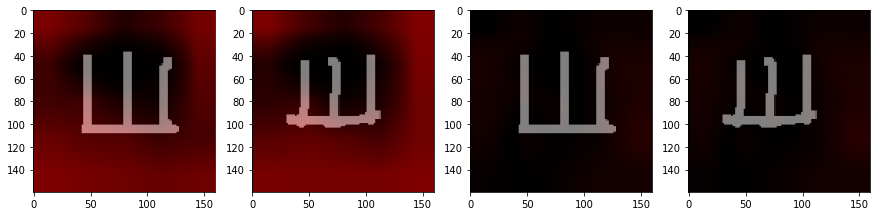

different | predicted : different


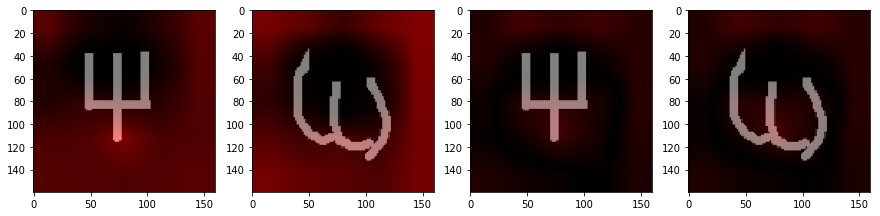

different | predicted : different


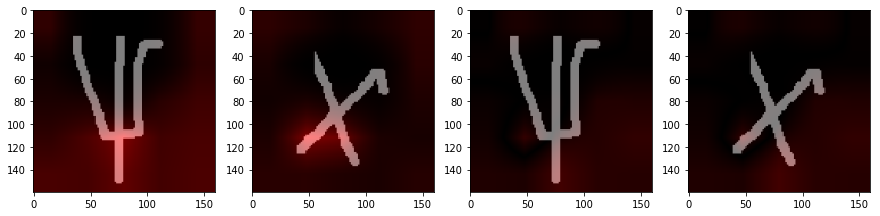

different | predicted : different


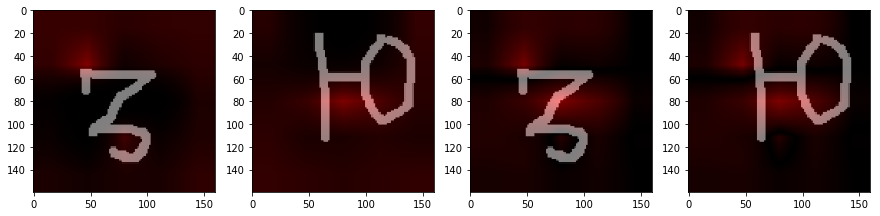

different | predicted : different


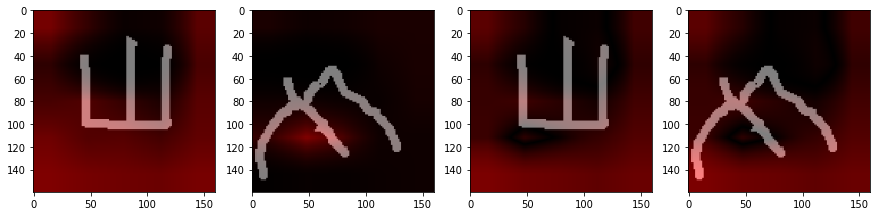

different | predicted : same


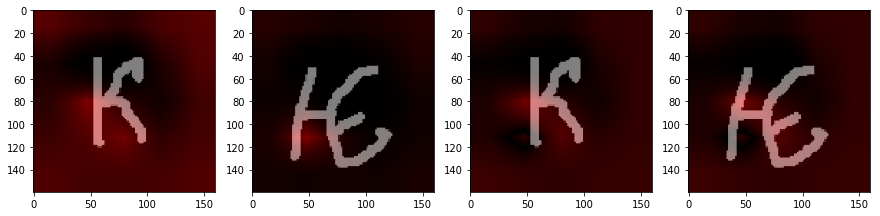

different | predicted : different


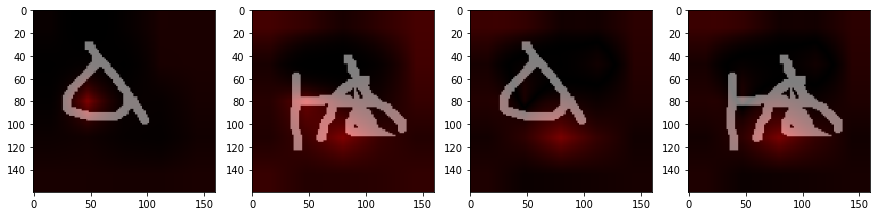

different | predicted : different


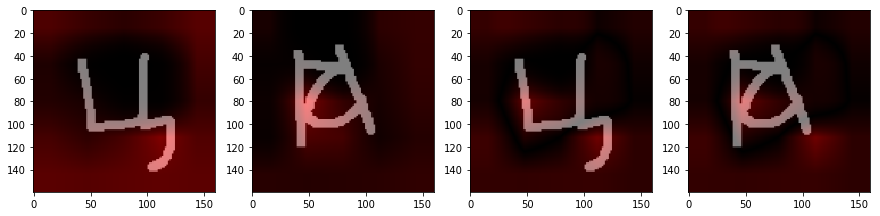

different | predicted : different


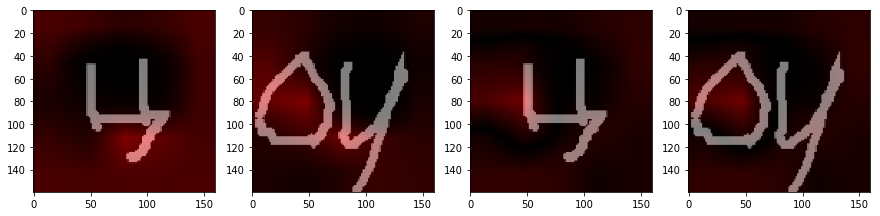

In [44]:
[x1,x2], t = next(batch_generator(np.array([evalute_alphabet]),
                                  shape = input_shape,
                                  batch_size = 16, load_img=False))
y = siamese_model.predict([x1,x2])
y= np.round(y).flatten() 
plt.figure(figsize=[40,40])
a_map1 = attention_map(siamese_model, x1)
a_map2 = attention_map(siamese_model, x2)

min_v = min([a_map1.min(),a_map2.min()])
max_v = max([a_map1.max(),a_map2.max()])
a_map1 = ((a_map1-min_v)/(max_v-min_v))
a_map2 = ((a_map2-min_v)/(max_v-min_v))
for ii in range(y.shape[0]):
    delta = abs(a_map2[ii] - a_map1[ii])
    f, axarr = plt.subplots(1,4,figsize=(15,15))
    title = ['same','different',][int(t[ii])]+ " | predicted : "+['same','different',][int(y[ii])]
    print(title)
    tmp1 = int2float(cv2.cvtColor(float2int(x1[ii][:,:,0]), cv2.COLOR_GRAY2RGB))/2
    tmp2 = int2float(cv2.cvtColor(float2int(x2[ii][:,:,0]), cv2.COLOR_GRAY2RGB))/2
    plot1= tmp1.copy() ; plot1[:,:,0]+=a_map1[ii]/2
    plot2= tmp2.copy() ; plot2[:,:,0]+=a_map2[ii]/2
    tmp1[:,:,0]+=delta/2 ; tmp2[:,:,0]+=delta/2
    axarr[0].imshow(plot1) ; axarr[1].imshow(plot2)
    axarr[2].imshow(tmp1)  ; axarr[3].imshow(tmp2)
    plt.show()

In [ ]:
# from keras import backend as K 
# #credit to sean goldfarb
# def attention_map(siamese_model, images):
#     inner_model = siamese_model.layers[-3]
#     siamese_dense_w = K.eval(siamese_model.layers[-1].weights[0])
#     labels = inner_model.predict(images)
#     for jj in range(labels.shape[0]):
#         labels[jj]*=siamese_dense_w[0]
        
#     labels = labels.argmax(1)
#     print(inner_model.predict(images).shape)
#     kernel = K.eval(inner_model.get_layer('conv_preds').weights[0])[0, 0, :, :]
#     for jj in range(kernel.shape[0]):
#         kernel[jj]*=siamese_dense_w[0]

#     feature = Model(inner_model.inputs, inner_model.get_layer('reshape_1').output).predict(images)[:,0,0,:]
#     feature_map = Model(inner_model.inputs, inner_model.get_layer('conv_pw_13_relu').output).predict(images)
    
#     for img in range(len(images)):
#         for index in range(kernel.shape[0]):
#             feature_map[img][:,:,index] *= feature[img, index] * kernel[index, int(labels[img])]
    
#     feature_map = feature_map.mean(axis=3)
#     a_map = list()
#     for img in range(len(images)):
#         a_map.append(cv2.resize(normalize(feature_map[img]), (images.shape[2], images.shape[1])))
    
#     return np.array(a_map)**3

## A Try To Handle The Signature OFF-Line Verification Challenge With  Same Features

will probably fail but lets try it

In [45]:
import re 

class SignatureDataset():
  
    def __init__(self ,path):
        self.path = path
    
    labels = ['REAL','FORGEN']
        
    def get_label(y):
        return SignatureDataset.labels[int(np.round(y))]
    
    #Kagel Signature syntax PPPIIISSS
    #P - is the person who sign the signature
    #I - is the inex of the signatue
    #S - is the preson who the signatue belong to
    def load_data(self,test_ratio = 0.2):
        REAL_KEY = 'REAL';FORGEN_KEY = 'FORGEN'
        C_dic = dict();path_dic = dict()
        not_real_counter = 0  
        not_forgen_counter = 0 
        for ii,row in enumerate(os.walk(self.path)):# row = tuple (path,Dirs,Files)
            path_1,dic_1,data_1 = row
            #print(path_1)
            for file_name in data_1:
                name = file_name.split(".")[0]
                if '_' in name:
                    K = 'S'
                    #SigComp2011 Dataset syntax
                    name,s_id = name.split('_')[0],name.split('_')[1]
                    if len(name) == 2:
                      #SigComp2011 test Dataset syntax
                        tmp = str(name)
                        name = str(s_id)
                        s_id = tmp
                        K = 'ST'
                    if len(name) == 3:
                        #Genuine Signature
                          org_writer = forg_writer = name   
                    else:
                        #Forgen Signature
                        org_writer = name[-3:]
                        forg_writer = name[:-3]
                else:
                    #Kagel Database syntax
                    K = 'K'
                    name = name.split(" ")[0]
                    name = re.sub('[^0-9]','', name)
                    org_writer = name[-3:] 
                    forg_writer = name[:3]
          
                key = K + org_writer
                if org_writer == forg_writer:
                    C_dic.setdefault(key,dict()).setdefault(REAL_KEY,[]).append(file_name)
                    path_dic.setdefault(key,dict()).setdefault(REAL_KEY,[]).append(path_1)
                else:
                    C_dic.setdefault(key,dict()).setdefault(FORGEN_KEY,[]).append(file_name)
                    path_dic.setdefault(key,dict()).setdefault(FORGEN_KEY,[]).append(path_1)  
                    #print('adding forgen '+ sign)
      
        train_data = []; train_target =[];test_data = []; test_target = [];    
      
        num_of_examples= len(C_dic.keys())
        num_of_test_to_add = int(num_of_examples*test_ratio)
        print('number of diffrent gunuine writers: ' + str(num_of_examples))
        test_indexes = [index for index in range(len(C_dic.keys()))] 
        random.shuffle(test_indexes)
        test_indexes = test_indexes[:num_of_test_to_add]
        print(test_indexes)
      
        key_index = 0
        for key in C_dic.keys():
            real_data = []; real_target = []
            
            #real_list = []  
            if(REAL_KEY not in C_dic[key].keys()):
                #count number of genuine signatures without forgen examples
                not_real_counter+=1
            else:  
                real_path_list = path_dic[key][REAL_KEY]
                real_list = C_dic[key][REAL_KEY]
                for real1_index in range(len(real_list)):
                    for real2_index in range(real1_index,len(real_list)):
                        if real1_index != real2_index:
                            real_data.append([os.path.join(real_path_list[real1_index],real_list[real1_index]) ,os.path.join(real_path_list[real2_index],real_list[real2_index])])
                            real_target.append(0.)
                            
            forgen_data = [];forgen_target = []
        
            if(FORGEN_KEY not in C_dic[key].keys()):
              #count number of forgen signatures without genuine examples
              not_forgen_counter+=1          
            else:
                forgen_path_list = path_dic[key][FORGEN_KEY]
                forgen_list = C_dic[key][FORGEN_KEY]
                for real1_index in range(len(real_list)):
                    for forgen2_index in range(len(forgen_list)):
                        forgen_data.append([os.path.join(real_path_list[real1_index],real_list[real1_index]) ,os.path.join(forgen_path_list[forgen2_index],forgen_list[forgen2_index])])
                        forgen_target.append(1.)  
            #remove data to balance the classes
            while len(real_data) != len(forgen_data):
                if len(real_data) < len(forgen_data):
                    rand = random.randrange(0,len(forgen_data))
                    del forgen_data[rand]
                    del forgen_target[rand]
                elif len(real_data) > len(forgen_data):
                    rand  = random.randrange(0,len(real_data))
                    del real_data[rand]
                    del real_target[rand]
            #split test _ train dataset                                                                     
            if num_of_test_to_add >  0 and key_index in test_indexes:
                test_data += real_data + forgen_data
                test_target += real_target + forgen_target
                num_of_test_to_add = num_of_test_to_add-1;
            else:
                train_data += real_data + forgen_data
                train_target += real_target + forgen_target
            key_index += 1
        
        X_train = np.array(train_data); Y_train = np.array(train_target)
        X_test = np.array(test_data); Y_test = np.array (test_target)
      
        print(str(not_real_counter), str(not_forgen_counter))
        print('train size =' + str(X_train.shape[0]) + ',test size =' + str(X_test.shape[0]))
        return X_train,Y_train,X_test,Y_test
    
def batch_generator_sig(X,Y,batch_size = 16,size = (224,224,3), random = True ,useAugs = False,
                        probability=0.2,noise_ratio=0 ,match_countors = False):
    start_index = 0
    X_ones = X[Y==1]
    X_zeros = X[Y==0]
    if random == True:
        np.random.shuffle(X_ones)
        np.random.shuffle(X_zeros)
    batch_counter = 0
    batch_size = batch_size//2
    number_of_batchs = (X.shape[0] // batch_size)
    while True:
        batch_counter =batch_counter% number_of_batchs
        img_paths = X_ones[batch_counter*batch_size:(1+batch_counter)*batch_size]
        img_paths = np.concatenate((img_paths,X_zeros[batch_counter*batch_size:(1+batch_counter)*batch_size]))
        img_labels = np.zeros(img_paths.shape[0])
        img_labels[:batch_size] = 1.
        imgs = [[cv2.imread(img1_path) ,cv2.imread(img2_path)] for img1_path,img2_path in img_paths]
        if useAugs == True:
            imgs = [apply_random_aug(x1,x2,probability,noise_ratio) for x1,x2 in imgs]
            
        imgs_np1 = np.array([init_image(img1,size ,match_countors=match_countors) for img1,_ in imgs])
        imgs_np2 = np.array([init_image(img2,size, match_countors=match_countors) for _,img2 in imgs])

        #img_labels[img_labels==1]-=0.001
        yield [imgs_np1,imgs_np2],img_labels.astype(np.float64)

In [46]:
dataset_path_sig = R'C:\Users\liori\Desktop\Projects\Computer vision\Computer Vision Curse Final Project\Sig_dataset'
sig_Dataset = SignatureDataset(dataset_path_sig)

In [47]:
X_train_sig,Y_train_sig,X_test_sig,Y_test_sig = sig_Dataset.load_data()

number of diffrent gunuine writers: 147
[126, 113, 41, 37, 59, 63, 69, 137, 72, 146, 7, 95, 82, 78, 116, 109, 52, 30, 76, 129, 66, 120, 11, 87, 10, 121, 22, 133, 45]
4 60
train size =28546,test size =6674


In [48]:
 #Shuffle the arrays by giving the permutation
permutation = np.random.permutation(X_test_sig.shape[0])
X_test_sig = X_test_sig[permutation] ; Y_test_sig = Y_test_sig[permutation]
#X_test_sig= X_test_sig[:2000] ; Y_test_sig =Y_test_sig[:2000]

imgs = [[cv2.imread(img1_path) ,cv2.imread(img2_path)] for img1_path,img2_path in X_test_sig]
imgs_np1 = np.array([init_image(img1,input_shape) for img1,_ in imgs])
imgs_np2 = np.array([init_image(img2,input_shape) for _,img2 in imgs])
X_test_sig_img=[imgs_np1,imgs_np2]

accuracy = 55.199%
Confusion matrix, without normalization


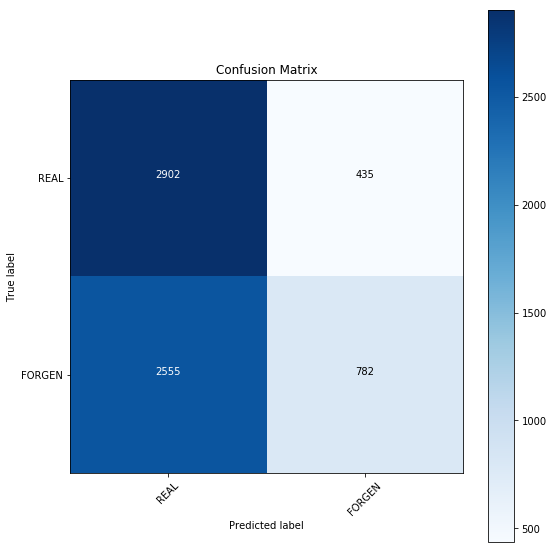

In [49]:
_ = evaluate_classifier(siamese_model,X_test_sig_img,Y_test_sig,
                        class_names=SignatureDataset.labels)

accuracy = 60.204%
Confusion matrix, without normalization


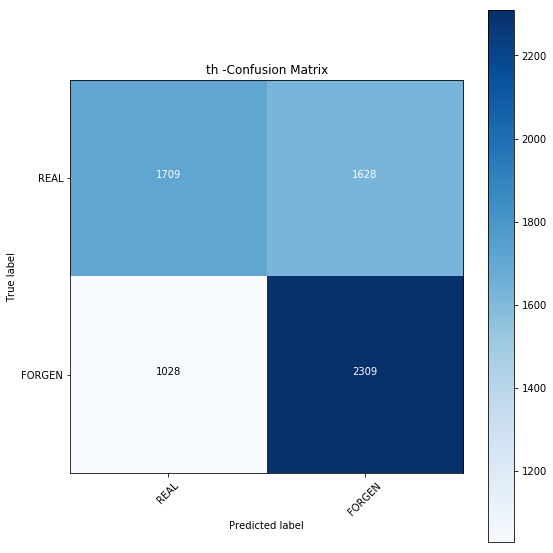

In [59]:
#P = siamese_model.predict(X_test_sig_img)
Y = P.copy()
Y[P>0.025] = 1
Y = np.round(Y).flatten() 
T = Y_test_sig[:Y.shape[0]]
display_confusion_matrix(T,Y,SignatureDataset.labels,figsize = [8,8],title ="th" )

In [63]:
permutation = np.random.permutation(X_train_sig.shape[0])
X_train_sig = X_train_sig[permutation] ; Y_train_sig = Y_train_sig[permutation]
X_train_sig= X_train_sig[:2000] ; Y_train_sig =Y_train_sig[:2000]

imgs = [[cv2.imread(img1_path) ,cv2.imread(img2_path)] for img1_path,img2_path in X_train_sig]
imgs_np1 = np.array([init_image(img1,input_shape) for img1,_ in imgs])
imgs_np2 = np.array([init_image(img2,input_shape) for _,img2 in imgs])
X_train_sig_img=[imgs_np1,imgs_np2]

In [64]:
siamese_model.layers

In [65]:
#take L1 features vectors from the siamese network
featuers_model = Model(siamese_model.inputs,siamese_model.layers[-2].output)

train_loc_vector_sig = featuers_model.predict(X_train_sig_img)
test_loc_vector_sig = featuers_model.predict(X_test_sig_img)

#feature vector after siamese network's linear transformation (multiply by the weights)
siamese_dense_w = K.eval(siamese_model.layers[-1].weights[0]).flatten()
train_loc_vector_sig[:] = train_loc_vector_sig[:]*(siamese_dense_w)    
test_loc_vector_sig[:]  = test_loc_vector_sig[:]*(siamese_dense_w)   

#features vectors shape 
train_loc_vector_sig.shape , test_loc_vector_sig.shape

((2000, 1000), (6674, 1000))

accuracy = 60.788%
Confusion matrix, without normalization


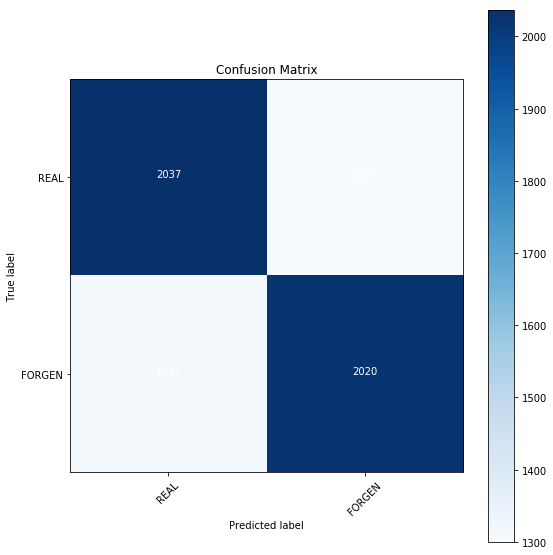

array([[2037, 1300],
       [1317, 2020]], dtype=int64)

In [74]:
classifier_knn = KNN(n_neighbors=3) 
classifier_knn.fit(train_loc_vector_sig,Y_train_sig)

T = evaluate_classifier(classifier_knn,test_loc_vector_sig,Y_test_sig,class_names=SignatureDataset.labels)
confusion_matrix(y_pred=T,y_true=Y_test_sig)

In [ ]:
# del siamese_model
# siamese_model = load_model('sig_siamese.h5')#('final_pro_omn2.h5') ##('final_pro_omn8.h5')

In [69]:
batch_size = 8
input_shape = (160,160,1)
train_gen_sig = batch_generator_sig(X_train_sig,Y_train_sig,batch_size = batch_size,size = input_shape,
                                    useAugs=True,probability=0.7,noise_ratio=0.15)
test_gen_sig =  batch_generator_sig(X_test_sig,Y_test_sig,batch_size = batch_size,size = input_shape)

In [62]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0, patience=20,
                                               verbose = 1, restore_best_weights=False)

In [ ]:
siamese_model.layers[2].trainable = True
siamese_model.compile(optimizer ='adadelta',
                loss='binary_crossentropy' ,
                  metrics = ['acc'])

FORGEN


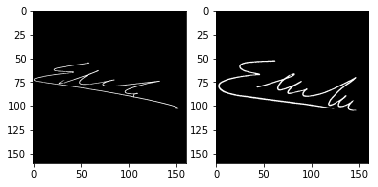

FORGEN


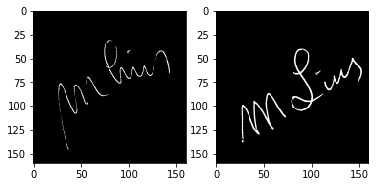

FORGEN


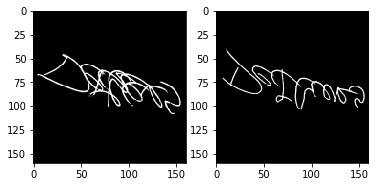

FORGEN


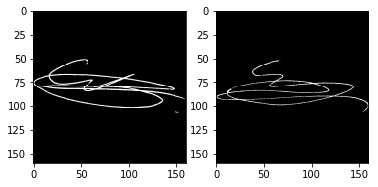

REAL


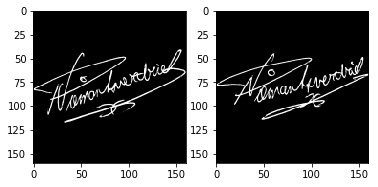

REAL


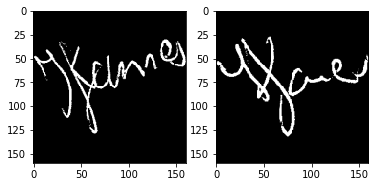

REAL


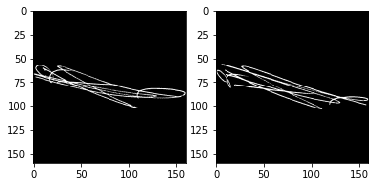

REAL


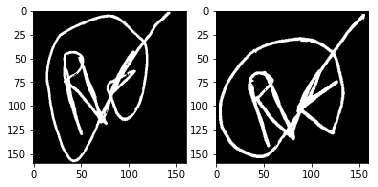

In [70]:
x,y = next(train_gen_sig)
for index in range(batch_size):
    print(SignatureDataset.get_label(y[index]))
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x[0][index][:,:,0],cmap='gray')
    axarr[1].imshow(x[1][index][:,:,0],cmap='gray')
    plt.show()

In [ ]:

his_sig2 = siamese_model.fit_generator(train_gen_sig,
                        steps_per_epoch = 50,
                        validation_steps = 5,
                        validation_data = test_gen_sig,
                        verbose=1, callbacks=[early_stopping],
                        epochs=1 )
epoch_his.append(his_sig2)

In [ ]:
_ = evaluate_classifier(siamese_model,X_test_sig_img,Y_test_sig,
                        class_names=SignatureDataset.labels)

In [ ]:
#take L1 features vectors from the siamese network
featuers_model = Model(siamese_model.inputs,siamese_model.layers[-2].output)

train_loc_vector_sig = featuers_model.predict(X_train_sig_img)
test_loc_vector_sig = featuers_model.predict(X_test_sig_img)

#feature vector after siamese network's linear transformation (multiply by the weights)
siamese_dense_w = K.eval(siamese_model.layers[-1].weights[0]).flatten()
train_loc_vector_sig[:] = train_loc_vector_sig[:]*(siamese_dense_w)    
test_loc_vector_sig[:]  = test_loc_vector_sig[:]*(siamese_dense_w)   

#features vectors shape 
train_loc_vector_sig.shape , test_loc_vector_sig.shape

classifier_knn = KNN(n_neighbors=3) 
classifier_knn.fit(train_loc_vector_sig,Y_train_sig)

_ = evaluate_classifier(classifier_knn,test_loc_vector_sig,Y_test_sig,class_names=SignatureDataset.labels)

In [ ]:

his_sig2 = siamese_model.fit_generator(train_gen_sig,
                        steps_per_epoch = 50,
                        validation_steps = 10,
                        validation_data = test_gen_sig,
                        verbose=1, callbacks=[early_stopping],
                        epochs=2 )
epoch_his.append(his_sig2)

In [ ]:
predicts = evaluate_classifier(siamese_model,X_test_sig_img,Y_test_sig,
                        class_names=SignatureDataset.labels)

In [ ]:
train_loc_vector_sig[:] = train_loc_vector_sig[:]*(siamese_dense_w)    
test_loc_vector_sig[:]  = test_loc_vector_sig[:]*(siamese_dense_w)   

#features vectors shape 
train_loc_vector_sig.shape , test_loc_vector_sig.shape

classifier_knn = KNN(n_neighbors=3) 
classifier_knn.fit(train_loc_vector_sig,Y_train_sig)

_ = evaluate_classifier(classifier_knn,test_loc_vector_sig,Y_test_sig,class_names=SignatureDataset.labels)

In [63]:
batch_size = 8
input_shape = (160,160,1)
train_gen_sig = batch_generator_sig(X_train_sig,Y_train_sig,batch_size = batch_size,size = input_shape,
                                    useAugs=True,probability=0.7,noise_ratio=0.15 ,match_countors = True)
test_gen_sig =  batch_generator_sig(X_test_sig,Y_test_sig,batch_size = batch_size,size = input_shape,match_countors = True)

In [ ]:
x,y = next(train_gen_sig)
for index in range(batch_size):
    print(SignatureDataset.get_label(y[index]))
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x[0][index][:,:,0],cmap='gray')
    axarr[1].imshow(x[1][index][:,:,0],cmap='gray')
    plt.show()

In [ ]:
del siamese_model_sig

In [ ]:
#load keras model from keras
keras_model =  keras.applications.mobilenet.MobileNet(weights= None, include_top=True ,input_shape=input_shape)
print(keras_model.layers[-1])
print(keras_model.layers[-2])

#remove softmax layer (layer -2)
keras_model.layers.pop()
keras_model.layers.pop()

#add sigmoid activation
inner_out = Activation('sigmoid', name='sigmoid')(keras_model.layers[-1].output)
inner_out = Flatten(name='flatten')(inner_out)

#use keras model as the shared inner model of the siamese network
inner_model= Model(inputs=[keras_model.input], outputs=[inner_out])

#create twin inputs for the siamese network
left_input = Input(input_shape)
right_input = Input(input_shape)

#get the twins output of the inner model
out_left = inner_model(left_input)
out_right = inner_model(right_input)

# Getting the L1 Distance between the 2 twins's outputs, 
#to evalute the features distance between the two inputs
L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))
out = L1_layer([out_left, out_right])

out = Dropout(0.05)(out)
#create a decision layer
out = Dense(1,activation='sigmoid')(out)

#create the siamese model
siamese_model_sig = Model([left_input, right_input], out)



siamese_model_sig.compile(optimizer ='adam',
                loss='binary_crossentropy' ,
                  metrics = ['acc'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0, patience=10,
                                               verbose = 1, restore_best_weights=True)

epoch_his = []



In [ ]:
his = siamese_model_sig.fit_generator(train_gen_sig,
                        steps_per_epoch = 250,
                        validation_steps = 20,
                        validation_data = test_gen_sig,
                        verbose=1, callbacks=[early_stopping],
                        epochs=30 )
epoch_his.append(his)

#plot training history
plt.subplot(121)
plt.plot(his.history['acc'])
plt.plot(his.history['val_acc'])
plt.title('acc')
plt.legend(['train acc', 'val acc'])
plt.subplot(122)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('loss')
plt.legend(['train loss', 'val loss'])
plt.show()